In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.max_rows', None)

from IPython.display import clear_output
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# Import Data

In [3]:
# gene to chromosome mapping

# Use table browser from UCSC
# Select full genome
# Export to csv

genome = pd.read_csv('genome.csv')

<ipython-input-3-0b47dad58844>:2: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  genome = pd.read_csv('../CCLE_analysis/genome.csv')


In [4]:
# Download all files from DepMap.org
# Go to Downloads
# Select files from drop down menus and download directly to your computer

# Import Sample Info
samples = pd.read_csv("sample_info.csv")
ccle = samples[['DepMap_ID', 'CCLE_Name']]

# Import Copy Numbers
cn = pd.read_csv("CCLE_gene_cn.csv")
cn.rename(columns={'Unnamed: 0':'DepMap_ID'}, inplace=True)
cn = ccle.merge(cn, on='DepMap_ID')  # Add CCLE_Names
cn.columns = [i.split(' ')[0] for i in cn.columns]  # Change names to HUGO symbol names

# Import gene expression
ge = pd.read_csv("CCLE_expression.csv")
ge.rename(columns={'Unnamed: 0':'DepMap_ID'}, inplace=True)
ge.columns = [i.split(' ')[0] for i in ge.columns]
ge = ccle.merge(ge, on='DepMap_ID')
#ge

In [12]:
# import CytoCellDB main master dataframe

ECDNA_master = pd.read_csv('ECDNA_Catalogue_MASTER.csv', index_col=None)
ECDNA_master.head(2)

,CCLE_Name_Format,ECDNA,HSR,Validation source,WGS coordinates,ATAC-seq,Long read DNA,RNA coordinates,RNA notes,single cell CNV,Hi-C,DepMap (CNV) notes,notes,notes - genes_on_ecDNA,AA prediction,Amplicon Repository AA Prediction,AA -AMP Type,AA - genes_on_ecDNA,AA_AMP_Max_CN,AA_AMP_Median_CN,AA_Complexity_Scores,CH prediction1,CH - genes on ecDNA,CH prediction2,CH - genes on ecDNA.1,SS_prediction_Detailed,SS-High Confidence Chromosomes,SS - Low Confidence Chromosomes,cellosaurus,ATCC,DSMZ,Available karyotype,K_Parsing_complete,ATCC_karyotype_text,ATCC_DM,DSMZ_karyotype,DSMZ_DM,% polyploidy,ploidy classification,bimodal classification,modal chromosome number,modal range,marker chromosomes (average #),range of marker chromosomes,DM amounts,DM % of cells,HSR present,Chromosome loss,Chromosome gains,INS,DEL,ADD,DUP,TRANS,INV,DER,ISO,DIC,Y chromosome presence,Karyo- comments,Other notes,DepMap_ID,cell_line_name,stripped_cell_line_name,alias,COSMICID,Notes on subtype,sex,source,RRID,WTSI_Master_Cell_ID,sample_collection_site,primary_or_metastasis,primary_disease,Subtype,age,Sanger_Model_ID,depmap_public_comments,lineage,lineage_subtype,lineage_sub_subtype,lineage_molecular_subtype,culture_type
0,HCC827_LUNG,N,Y,Turner et al. 2017 Nature,SRR8639147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,Y,"['Complex non-cyclic', 'Linear amplification',...","['EGFR', 'EGFR-AS1', 'SEC61G', 'VSTM2A', 'VSTM...","{'amplicon1': 53.78588728071532, 'amplicon2': ...","{'amplicon1': 10.821108606796622, 'amplicon2':...","{'amplicon1': 1.8426711299973788, 'amplicon2':...",NaN,NaN,negative,NaN,NaN,NaN,NaN,HCC827,CRL-2868,ACC-566,Y,Y,NaN,NaN,human flat-moded hypotriploid karyotype with 6...,Y,6.0,hypotriploid,N,62.0,54-66,3.0,NaN,0-4,NaN,Y,"1, 9, 10, 15, 17, 18, 21, 22",7,NaN,NaN,"add(X)(p11),add(3)(p11),add(6)(p21),add(7)(p12...",dup(2)(p1?p2?),NaN,NaN,der(21;22)(q10;q10),NaN,NaN,NaN,NaN,NaN,ACH-000012,HCC827,HCC827,NaN,1240146.0,NaN,Female,ATCC,CVCL_2063,354.0,lung,Primary,Lung Cancer,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",39.0,SIDM01067,NaN,lung,NSCLC,NSCLC_adenocarcinoma,NaN,Adherent
1,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Y,Y,"ATCC, Turner et al. 2017 Nature",SRR4009290,"SRX1621361,SRX1621362,SRX1621363,SRX1962076,SR...",NaN,SRX12417259,Treated with PBS,NaN,NaN,NaN,NaN,NaN,Y,NaN,['ecDNA'],"['CASC11', 'MYC']",{'amplicon1': 44.24671271568901},{'amplicon1': 22.199247290958315},{'amplicon1': 0.6492684363557939},Y,NaN,NaN,NaN,NaN,NaN,NaN,HL-60,CCL-240,ACC-3,Y,Y,The stemline chromosome number is pseudodiploi...,Y,human flat-moded hypotetraploid karyotype with...,Y,1.5,"mix (diploid, hypotetraploid, hypodiploid)",N,NaN,82-88,3.0,2-5,varied,all,Y,"8, 16, 17","18, 22",ins(1;8)(p?31;q24hsr)x2,del(11)(q23.1q23.2),"add(6)(q27)x2,add(18)(q21)",NaN,NaN,NaN,"der(5)t(5;17)(q11;q11)x2,der(9)del(9)(p13)t(9;...",NaN,NaN,NaN,c-myc amplicons present in der(1) and in both ...,c-myc amplicons present in der(1) and in both ...,ACH-000002,HL-60,HL60,NaN,905938.0,NaN,Female,ATCC,CVCL_0002,55.0,haematopoietic_and_lymphoid_tissue,Primary,Leukemia,"Acute Myelogenous Leukemia (AML), M3 (Promyelo...",35.0,SIDM00829,NaN,blood,AML,M3,NaN,Suspension


# Aggregate Copy Number vs Gene expression

In [6]:
cn_melted = pd.melt(cn, id_vars=['DepMap_ID', 'CCLE_Name'], var_name='Gene', value_name='CN')
GE_melted = pd.melt(ge, id_vars=['DepMap_ID', 'CCLE_Name'], var_name='Gene', value_name='GE')
omics2 = pd.merge(cn_melted, GE_melted, on=['DepMap_ID', 'CCLE_Name', 'Gene'])
omics2 = omics2.dropna()  # Drop rows with missing CN or GE.
print(str(len(omics2['CCLE_Name'].unique())) + ' cell lines in common.')
print(str(len(omics2['Gene'].unique())) + ' genes in common.')
omics2.head(2)

1371 cell lines in common.
19164 genes in common.


,DepMap_ID,CCLE_Name,Gene,CN,GE
0,ACH-000001,NIHOVCAR3_OVARY,OR4F5,1.465784,0.0
1,ACH-000002,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,OR4F5,1.041792,0.0


# Labeling Data

Text(0.5, 1.0, 'GE and CN Scores of ERBB2 in Different Cell Lines')

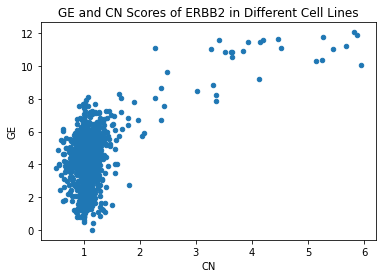

In [6]:
# Plot ERBB2
erbb2_2 = omics2[omics2['Gene']=='ERBB2']
erbb2_2.plot.scatter('CN', 'GE')
plt.title('GE and CN Scores of ERBB2 in Different Cell Lines')

Text(0.5, 1.0, 'GE and CN Scores of MYC in Different Cell Lines')

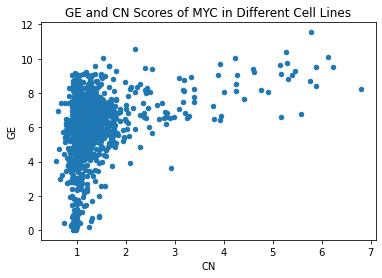

In [7]:
# Plot MYC
myc_2 = omics2[omics2['Gene']=='MYC']
myc_2.plot.scatter('CN', 'GE')
plt.title('GE and CN Scores of MYC in Different Cell Lines')

## Manual Labeling

We are looking for cell lines in which a particular gene is found in high copy numbers and its knockout has a strong effect. We choose manual thresholds according to ERBB2's plot as a starting point. Blue points are cell lines of interest for us.

,DepMap_ID,CCLE_Name,Gene,CN,GE,Manual
10618667,ACH-000277,HCC1419_BREAST,ERBB2,4.198499,11.592177,1
10618780,ACH-000392,CALU3_LUNG,ERBB2,5.145790,10.281582,1
10618814,ACH-000427,NCIN87_STOMACH,ERBB2,5.270205,11.756306,1
10618867,ACH-000481,NCIH2170_LUNG,ERBB2,5.671834,11.206892,1
10618939,ACH-000554,UACC893_BREAST,ERBB2,4.464675,11.648582,1
10619062,ACH-000679,OE19_OESOPHAGUS,ERBB2,5.822285,12.050631,1
10619189,ACH-000809,KYSE410_OESOPHAGUS,ERBB2,5.259419,10.383920,1
10619208,ACH-000828,ZR7530_BREAST,ERBB2,4.138329,11.437388,1
10619239,ACH-000859,HCC1954_BREAST,ERBB2,5.880057,11.903694,1
10619297,ACH-000917,TE4_OESOPHAGUS,ERBB2,5.450533,11.000845,1


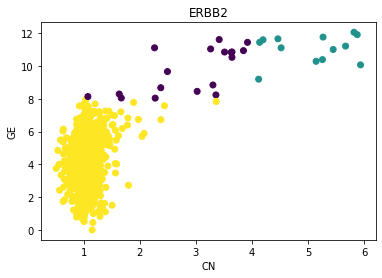

In [8]:
# Label with manual limits (CN vs GE data)

# In Pandas, there are many methods for labeling rows according to the values in different columns.
# np.select is one of the vectorized methods. Meaning, it utilizes the dataframe structure of our data.
# Instead of looping through each row, it processes as much as it can all at once.

omics2['Manual'] = np.select([
                            ((omics2['CN'] > 4) & (omics2['GE'] > 8)),
                            ((omics2['CN'] < 4) & (omics2['GE'] > 8)),
                            ((omics2['CN'] < 4) & (omics2['GE'] < 8))
                           ],
                           [1, 0, 2], default=3)

# Plot ERBB2
erbb2_ge = omics2[omics2['Gene']=='ERBB2']
plt.scatter(erbb2_ge['CN'], erbb2_ge['GE'], c=erbb2_ge['Manual'])
plt.xlabel('CN')
plt.ylabel('GE')
plt.title('ERBB2');  # Semicolon stops Jupyter from printing the output of matplotlib functions.

display(erbb2_ge[erbb2_ge['Manual']==1])

,DepMap_ID,CCLE_Name,Gene,CN,GE,Manual,Manualv2
10618410,ACH-000017,SKBR3_BREAST,ERBB2,3.512129,10.844706,0,1
10618507,ACH-000117,EFM192A_BREAST,ERBB2,3.921662,11.436035,0,1
10618638,ACH-000248,AU565_BREAST,ERBB2,3.416056,11.605989,0,1
10618667,ACH-000277,HCC1419_BREAST,ERBB2,4.198499,11.592177,1,1
10618771,ACH-000383,OE33_OESOPHAGUS,ERBB2,3.304745,8.839330,0,1
10618780,ACH-000392,CALU3_LUNG,ERBB2,5.145790,10.281582,1,1
10618814,ACH-000427,NCIN87_STOMACH,ERBB2,5.270205,11.756306,1,1
10618867,ACH-000481,NCIH2170_LUNG,ERBB2,5.671834,11.206892,1,1
10618939,ACH-000554,UACC893_BREAST,ERBB2,4.464675,11.648582,1,1
10618953,ACH-000568,UACC812_BREAST,ERBB2,3.849254,10.930811,0,1


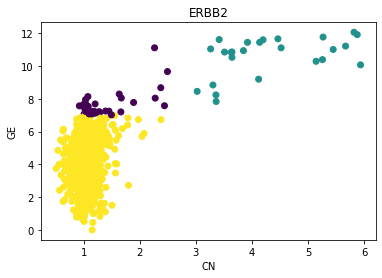

In [9]:
# Label with manual limits (CN vs GE) - less strict

# In Pandas, there are many methods for labeling rows according to the values in different columns.
# np.select is one of the vectorized methods. Meaning, it utilizes the dataframe structure of our data.
# Instead of looping through each row, it processes as much as it can all at once.

omics2['Manualv2'] = np.select([
                            ((omics2['CN'] > 3) & (omics2['GE'] > 7)),
                            ((omics2['CN'] < 3) & (omics2['GE'] > 7)),
                            ((omics2['CN'] < 3) & (omics2['GE'] < 7))
                           ],
                           [1, 0, 2], default=3)

# Plot ERBB2
erbb2_ge = omics2[omics2['Gene']=='ERBB2']
plt.scatter(erbb2_ge['CN'], erbb2_ge['GE'], c=erbb2_ge['Manualv2'])
plt.xlabel('CN')
plt.ylabel('GE')
plt.title('ERBB2');  # Semicolon stops Jupyter from printing the output of matplotlib functions.

display(erbb2_ge[erbb2_ge['Manualv2']==1])

,DepMap_ID,CCLE_Name,Gene,CN,GE,Manual,cell_CN_999,cell_GE_97,gene_CN_99,gene_GE_97,N_cell_CN_999,N_cell_GE_97,N_gene_CN_99,N_gene_GE_97,cell_CN_diff,cell_CN_Q,cell_GE_diff,cell_GE_Q,gene_CN_diff,gene_CN_Q,gene_gene_diff,gene_gene_Q,Manualv2
3589760,ACH-000491,NCIH716_LARGE_INTESTINE,FGFR2,4.871174,11.960726,1,2.084179,7.663178,1.409361,6.043283,20,575,14,42,2.786995,0.139350,4.297548,0.007474,3.461813,0.247272,5.917443,0.140892,1
3589849,ACH-000581,SNU16_STOMACH,FGFR2,5.972256,11.070255,1,2.226590,7.512124,1.409361,6.043283,19,575,14,42,3.745666,0.197140,3.558131,0.006188,4.562895,0.325921,5.026973,0.119690,1
3590057,ACH-000793,KATOIII_STOMACH,FGFR2,6.040817,11.827422,1,2.442196,7.776065,1.409361,6.043283,14,575,14,42,3.598622,0.257044,4.051357,0.007046,4.631457,0.330818,5.784140,0.137718,1
3590389,ACH-001396,SUM52PE_BREAST,FGFR2,5.013520,10.360628,1,2.770461,7.151157,1.409361,6.043283,17,575,14,42,2.243059,0.131945,3.209471,0.005582,3.604159,0.257440,4.317345,0.102794,1
3590566,ACH-001819,MFM223_BREAST,FGFR2,6.326611,10.638255,1,3.301280,7.869555,1.409361,6.043283,17,575,14,42,3.025331,0.177961,2.768700,0.004815,4.917250,0.351232,4.594972,0.109404,1


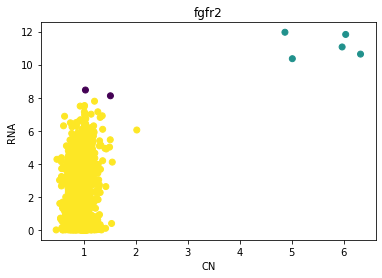

In [9]:
# Plot FGFR2

fgfr2 = omics2[omics2['Gene']=='FGFR2']
plt.scatter(fgfr2['CN'], fgfr2['GE'], c=fgfr2['Manual'])
plt.xlabel('CN')
plt.ylabel('RNA')
plt.title('fgfr2');  # Semicolon stops Jupyter from printing the output of matplotlib functions.

display(fgfr2[fgfr2['Manual']==1])
plt.savefig("../CCLE_analysis/figures_for_ECDB_paper/fgfr2_cnv_ge_manual.svg", format='svg')

,DepMap_ID,CCLE_Name,Gene,CN,GE,Manual,cell_CN_999,cell_GE_97,gene_CN_99,gene_GE_97,N_cell_CN_999,N_cell_GE_97,N_gene_CN_99,N_gene_GE_97,cell_CN_diff,cell_CN_Q,cell_GE_diff,cell_GE_Q,gene_CN_diff,gene_CN_Q,gene_gene_diff,gene_gene_Q,Manualv2
3589760,ACH-000491,NCIH716_LARGE_INTESTINE,FGFR2,4.871174,11.960726,1,2.084179,7.663178,1.409361,6.043283,20,575,14,42,2.786995,0.139350,4.297548,0.007474,3.461813,0.247272,5.917443,0.140892,1
3589849,ACH-000581,SNU16_STOMACH,FGFR2,5.972256,11.070255,1,2.226590,7.512124,1.409361,6.043283,19,575,14,42,3.745666,0.197140,3.558131,0.006188,4.562895,0.325921,5.026973,0.119690,1
3590057,ACH-000793,KATOIII_STOMACH,FGFR2,6.040817,11.827422,1,2.442196,7.776065,1.409361,6.043283,14,575,14,42,3.598622,0.257044,4.051357,0.007046,4.631457,0.330818,5.784140,0.137718,1
3590389,ACH-001396,SUM52PE_BREAST,FGFR2,5.013520,10.360628,1,2.770461,7.151157,1.409361,6.043283,17,575,14,42,2.243059,0.131945,3.209471,0.005582,3.604159,0.257440,4.317345,0.102794,1
3590566,ACH-001819,MFM223_BREAST,FGFR2,6.326611,10.638255,1,3.301280,7.869555,1.409361,6.043283,17,575,14,42,3.025331,0.177961,2.768700,0.004815,4.917250,0.351232,4.594972,0.109404,1


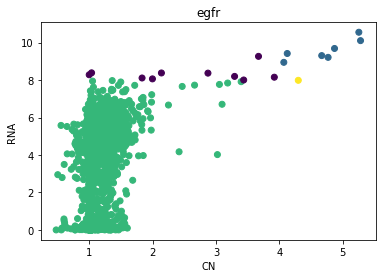

In [10]:
# Plot EGFR

egfr = omics2[omics2['Gene']=='EGFR']
plt.scatter(egfr['CN'], egfr['GE'], c=egfr['Manual'])
plt.xlabel('CN')
plt.ylabel('RNA')
plt.title('egfr');  # Semicolon stops Jupyter from printing the output of matplotlib functions.

display(fgfr2[fgfr2['Manual']==1])
plt.savefig("../CCLE_analysis/figures_for_ECDB_paper/egfr_cnv_ge_manual.svg", format='svg')

,DepMap_ID,CCLE_Name,Gene,CN,GE,Manual,cell_CN_999,cell_GE_97,gene_CN_99,gene_GE_97,N_cell_CN_999,N_cell_GE_97,N_gene_CN_99,N_gene_GE_97,cell_CN_diff,cell_CN_Q,cell_GE_diff,cell_GE_Q,gene_CN_diff,gene_CN_Q,gene_gene_diff,gene_gene_Q,Manualv2
10618667,ACH-000277,HCC1419_BREAST,ERBB2,4.198499,11.592177,1,3.802415,7.739097,3.870977,7.44579,20,575,14,42,0.396084,0.019804,3.853080,0.006701,0.327522,0.023394,4.146387,0.098724,1
10618780,ACH-000392,CALU3_LUNG,ERBB2,5.145790,10.281582,1,3.043491,7.197893,3.870977,7.44579,18,575,14,42,2.102299,0.116794,3.083689,0.005363,1.274813,0.091058,2.835793,0.067519,1
10618814,ACH-000427,NCIN87_STOMACH,ERBB2,5.270205,11.756306,1,2.505488,7.497488,3.870977,7.44579,13,575,14,42,2.764717,0.212671,4.258818,0.007407,1.399228,0.099945,4.310516,0.102631,1
10618867,ACH-000481,NCIH2170_LUNG,ERBB2,5.671834,11.206892,1,3.890737,7.520421,3.870977,7.44579,14,575,14,42,1.781097,0.127221,3.686472,0.006411,1.800857,0.128633,3.761103,0.089550,1
10618939,ACH-000554,UACC893_BREAST,ERBB2,4.464675,11.648582,1,4.464675,7.579162,3.870977,7.44579,7,575,14,42,0.000000,0.000000,4.069420,0.007077,0.593698,0.042407,4.202793,0.100066,1
10619062,ACH-000679,OE19_OESOPHAGUS,ERBB2,5.822285,12.050631,1,3.216793,7.392412,3.870977,7.44579,17,575,14,42,2.605492,0.153264,4.658219,0.008101,1.951309,0.139379,4.604841,0.109639,1
10619189,ACH-000809,KYSE410_OESOPHAGUS,ERBB2,5.259419,10.383920,1,3.785304,7.333241,3.870977,7.44579,20,575,14,42,1.474114,0.073706,3.050679,0.005306,1.388442,0.099174,2.938131,0.069955,1
10619208,ACH-000828,ZR7530_BREAST,ERBB2,4.138329,11.437388,1,3.905146,7.518966,3.870977,7.44579,11,575,14,42,0.233182,0.021198,3.918422,0.006815,0.267352,0.019097,3.991598,0.095038,1
10619239,ACH-000859,HCC1954_BREAST,ERBB2,5.880057,11.903694,1,3.649254,7.874127,3.870977,7.44579,16,575,14,42,2.230803,0.139425,4.029567,0.007008,2.009080,0.143506,4.457904,0.106141,1
10619297,ACH-000917,TE4_OESOPHAGUS,ERBB2,5.450533,11.000845,1,2.818597,7.507441,3.870977,7.44579,11,575,14,42,2.631936,0.239267,3.493404,0.006075,1.579557,0.112825,3.555055,0.084644,1


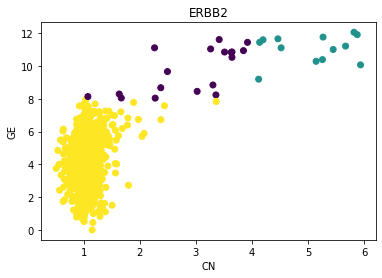

In [9]:
erbb2_ge = omics2[omics2['Gene']=='ERBB2']
plt.scatter(erbb2_ge['CN'], erbb2_ge['GE'], c=erbb2_ge['Manual'])
plt.xlabel('CN')
plt.ylabel('GE')
plt.title('ERBB2');  # Semicolon stops Jupyter from printing the output of matplotlib functions.

display(erbb2_ge[erbb2_ge['Manual']==1])
plt.savefig("../CCLE_analysis/figures_for_ECDB_paper/erbb2_cnv_ge_manual.svg", format='svg')

## Clustering Trials

We want to get a similar labeling scheme without using any prior information. So, we will try using different unsupervised clustreing algorithms to see if any of them give a similar result.

### DBSCAN

Estimated no. of clusters: 3
Estimated no. of noise points: 0


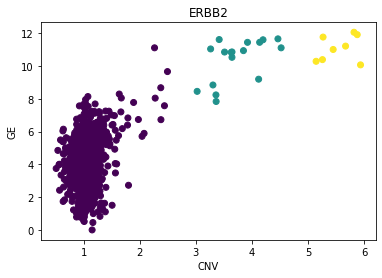

<Figure size 432x288 with 0 Axes>

In [11]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

db = StandardScaler().fit_transform(erbb2_ge[['CN','GE']])
db = DBSCAN(eps=1.2, min_samples=3).fit(db)

no_clusters = len(np.unique(db.labels_))
no_noise = np.sum(np.array(db.labels_) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

# Generate scatter plot for training data
plt.scatter(erbb2_ge['CN'], erbb2_ge['GE'], c=db.labels_.astype(float), marker="o", picker=True)
plt.title('ERBB2')
plt.xlabel('CNV')
plt.ylabel('GE')
plt.show()
plt.savefig("../CCLE_analysis/figures_for_ECDB_paper/erbb2_cnv_ge_dbscan.svg", format='svg')

### K Means Clustering

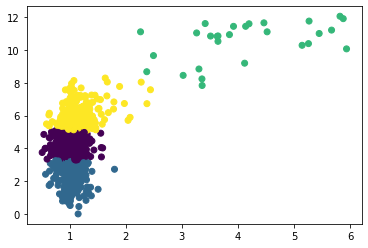

In [14]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4)
df_km = km.fit_predict(erbb2_ge[['CN','GE']])
plt.scatter(erbb2_ge['CN'], erbb2_ge['GE'], c=df_km)

### Gaussian Mixture

Text(0, 0.5, 'GE')

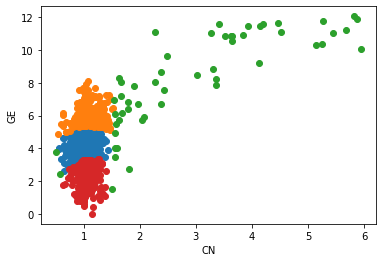

In [16]:
X = omics2[omics2['Gene']=='ERBB2'][['CN','GE']].to_numpy()

from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=4)
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1])

plt.xlabel('CN')
plt.ylabel('GE')

None of these methods are the kind of labeling we want. We can still take inspiration from Gaussian mixture and base our manual labeling on the statistics of our data.

## Statistical Labeling

Visually speaking, ERBB2 is a good model but other genes can have vastly different plots. If we base our labeling scheme only on ERBB2's statistics, we would be neglecting this difference.

In [ ]:
# Plot all genes

for gene, df in omics2.groupby('Gene'):
    plt.scatter(df['CN'], df['GE'], c=df['Manual'])
    plt.xlabel('CN')
    plt.ylabel('GE')
    plt.title(gene)
    plt.show()

A more generalized approach would be to decide on the thresholds according to the statistics of each gene. We could base our threshold on precentiles or standard deviatons. Let's look at the statistics for CN.

### CN Statistics

Text(0, 0.5, 'Frequency')

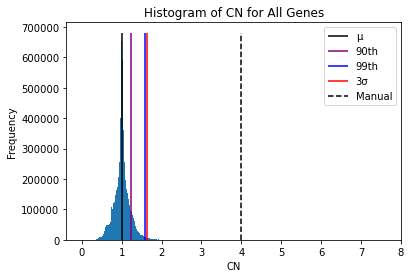

In [18]:
# Histogram of CN values

h = plt.hist(omics['CN'], bins=1000)

# Add thresholds
plt.vlines(np.mean(omics['CN']), 0, max(h[0]), color='black', label='μ')
plt.vlines(omics['CN'].quantile(0.9), 0, max(h[0]), color='purple', label='90th')
plt.vlines(omics['CN'].quantile(0.99), 0, max(h[0]), color='blue', label='99th')
plt.vlines(np.mean(omics['CN']) + np.std(omics['CN'])*3, 0, max(h[0]), color='red', label='3σ')
plt.vlines(4, 0, max(h[0]), color='black', linestyles='dashed', label='Manual')
plt.legend()
plt.title('Histogram of CN for All Genes')
plt.xlabel('CN')
plt.ylabel('Frequency')

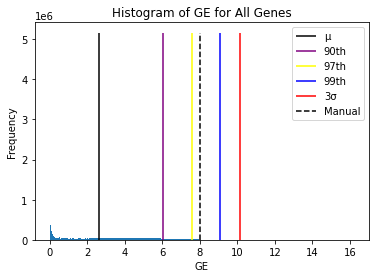

In [12]:
# Histogram of CN values

h = plt.hist(omics2['GE'], bins=1000)

# Add thresholds
plt.vlines(np.mean(omics2['GE']), 0, max(h[0]), color='black', label='μ')
plt.vlines(omics2['GE'].quantile(0.9), 0, max(h[0]), color='purple', label='90th')
plt.vlines(omics2['GE'].quantile(0.97), 0, max(h[0]), color='yellow', label='97th')
plt.vlines(omics2['GE'].quantile(0.99), 0, max(h[0]), color='blue', label='99th')
plt.vlines(np.mean(omics2['GE']) + np.std(omics2['GE'])*3, 0, max(h[0]), color='red', label='3σ')
plt.vlines(8, 0, max(h[0]), color='black', linestyles='dashed', label='Manual')
plt.legend()
plt.title('Histogram of GE for All Genes')
plt.xlabel('GE')
plt.ylabel('Frequency')
plt.savefig("../CCLE_analysis/figures_for_ECDB_paper/histogram_GE_all_genes_percentiles.svg", format='svg')

Let's zoom in by looking at genes that were manually labeled to be interesting for at least one cell line.

In [16]:
# Filter interesting genes.
ec_genes_ge = omics2[omics2['Manualv2']==1]['Gene']
ec_ge = omics2[omics2['Gene'].isin(ec_genes_ge)]

In [ ]:
# Histogram of CN values for manually selected genes.
h = plt.hist(ec_ko['CN'], bins=1000)

# Add thresholds
plt.vlines(np.mean(ec_ko['CN']), 0, max(h[0]), color='black', label='μ')
plt.vlines(ec_ko['CN'].quantile(0.9), 0, max(h[0]), color='purple', label='90th')
plt.vlines(ec_ko['CN'].quantile(0.97), 0, max(h[0]), color='yellow', label='97th')
plt.vlines(ec_ko['CN'].quantile(0.99), 0, max(h[0]), color='blue', label='99th')
plt.vlines(ec_ko['CN'].quantile(0.995), 0, max(h[0]), color='orange', label='99.5th')
plt.vlines(np.mean(ec_ko['CN']) + np.std(ec_ko['CN'])*3, 0, max(h[0]), color='red', label='3σ')
plt.vlines(4, 0, max(h[0]), color='black', linestyles='dashed', label='Manual')
plt.legend()
plt.title('Histogram of CN for Labeled Genes')
plt.xlabel('CN')
plt.ylabel('Frequency')


Using the 99th percentile or 3σ looks like a good option. Let's look at it on a gene by gene level.

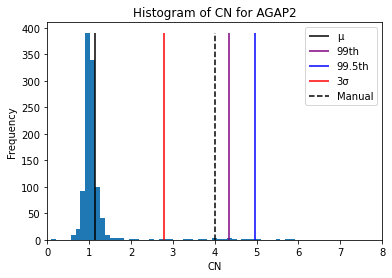

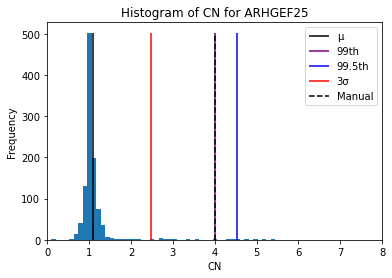

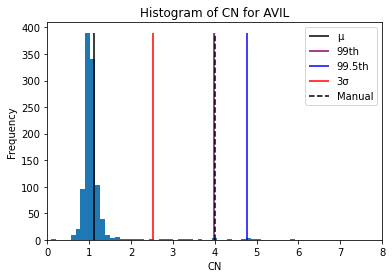

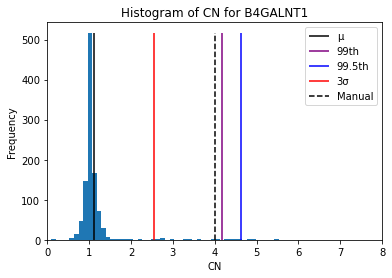

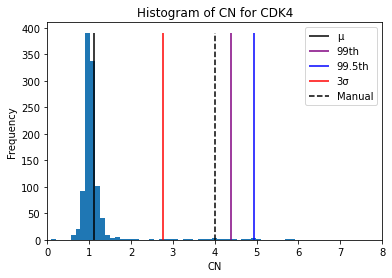

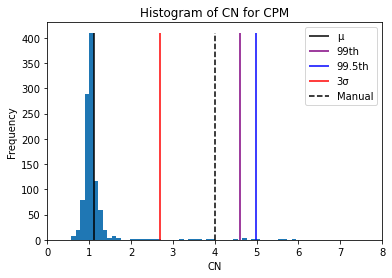

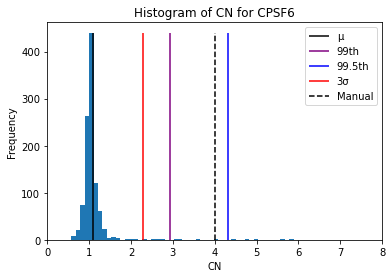

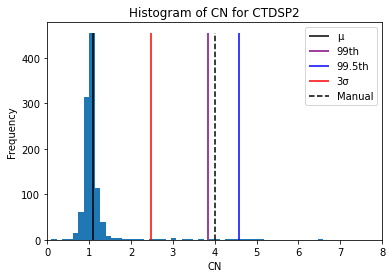

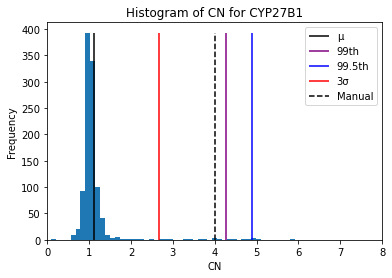

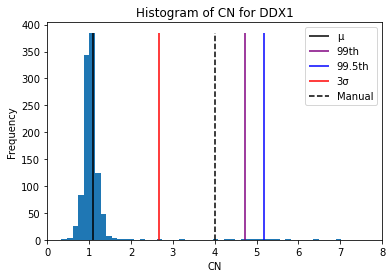

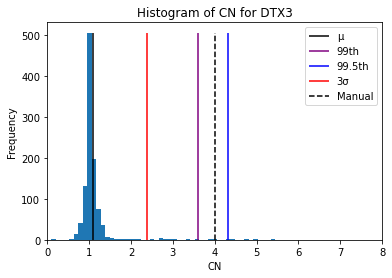

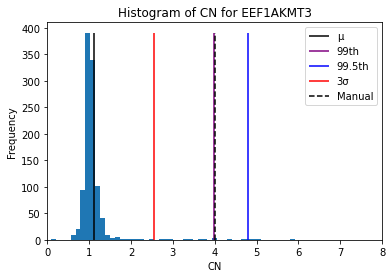

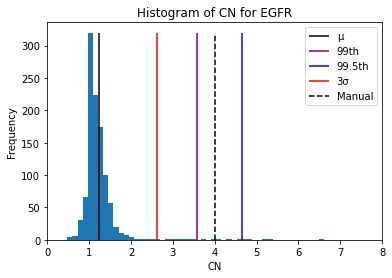

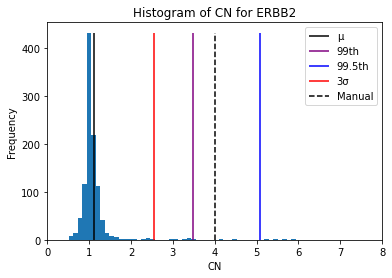

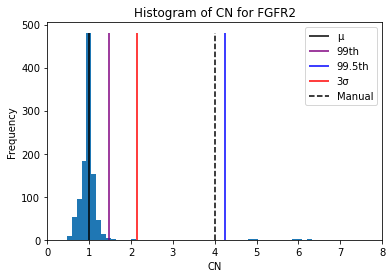

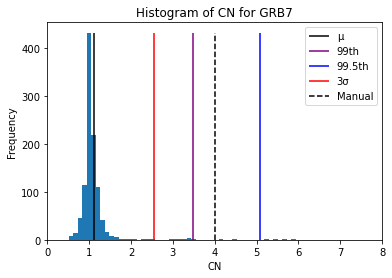

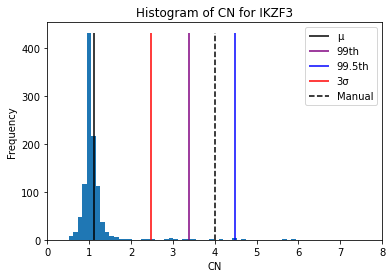

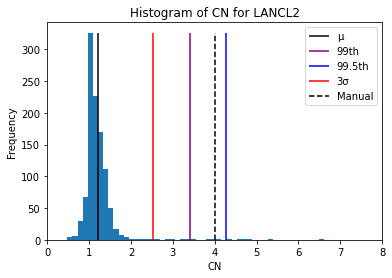

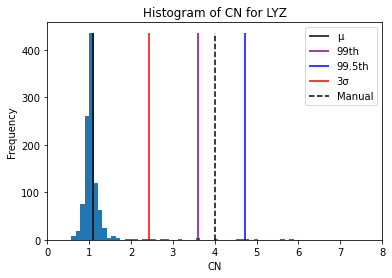

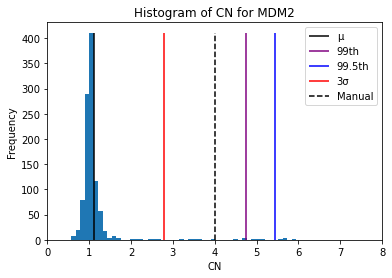

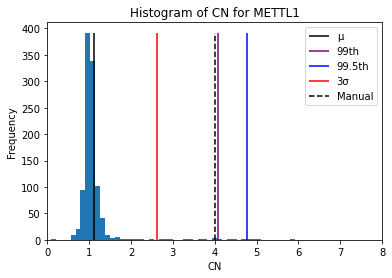

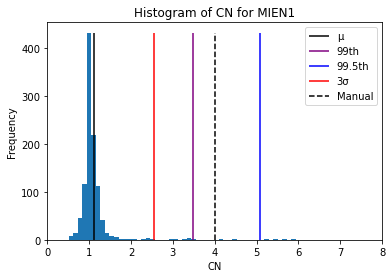

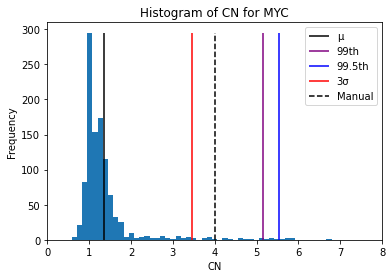

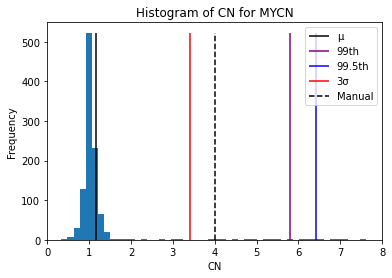

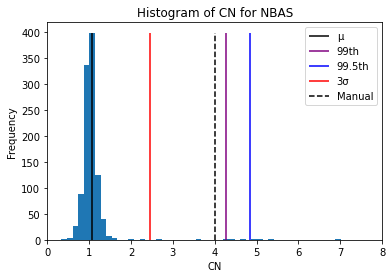

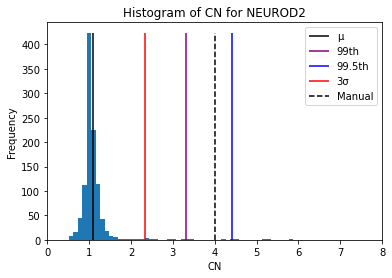

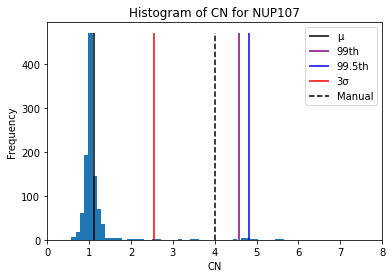

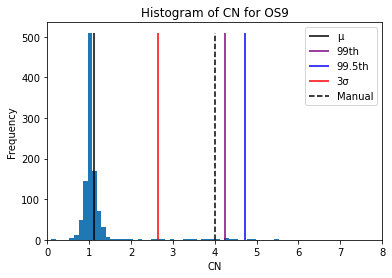

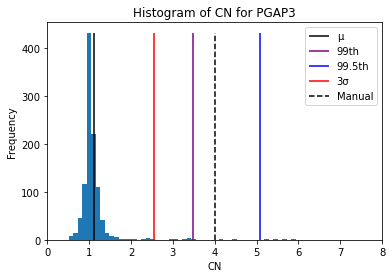

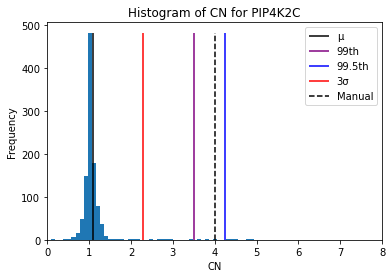

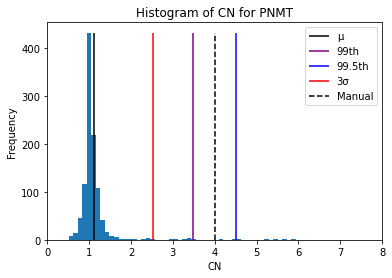

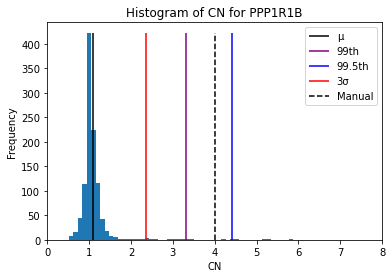

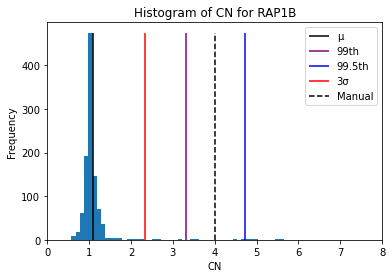

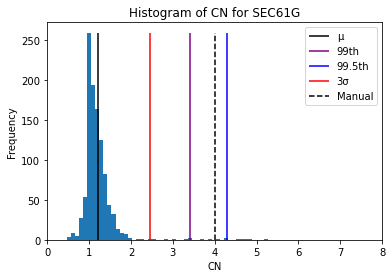

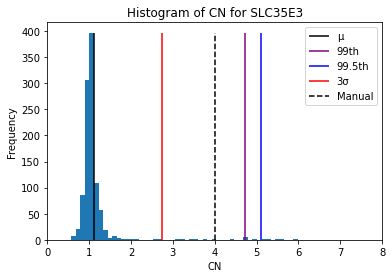

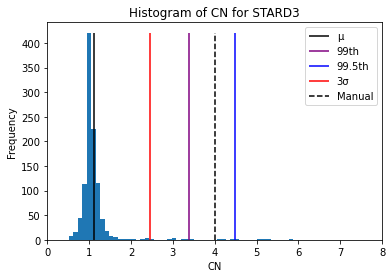

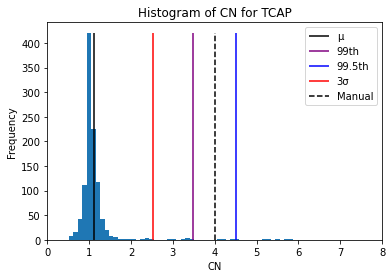

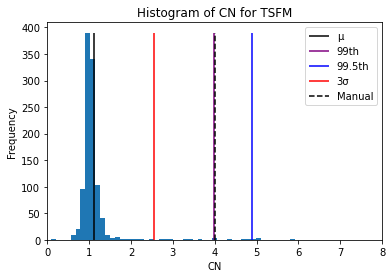

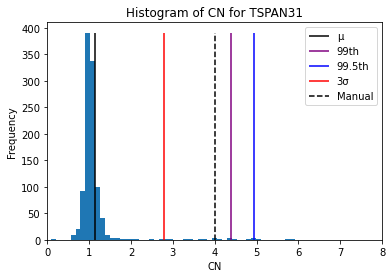

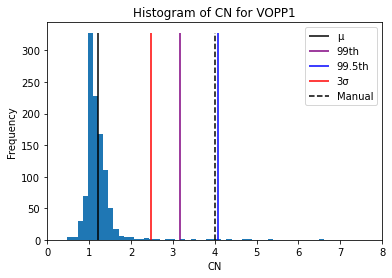

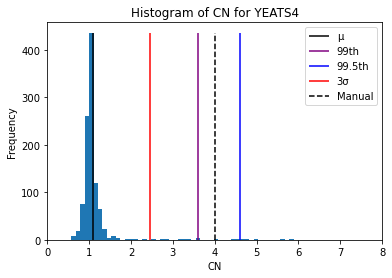

In [96]:
# Make CN histogram for each gene
genes_CN_995 = []
cells_CN_995 = []

for gene, df in ec_ko.groupby('Gene'):
    #label1_count = df['Manual'].ec_ko(1).sum()  # Count the labeled cell lines for this gene.
    # if label1_count > 0:  # If you want to consider labeled genes.
    if (df['CN'].quantile(0.995) >=4) &(len(df[df.CN>=df['CN'].quantile(0.995)]) > 5):
        genes_CN_995.append(gene)
        for i in df[df.CN>=df['CN'].quantile(0.995)].CCLE_Name:
            if i not in cells_CN_995:
                cells_CN_995.append(i)
        
        h = plt.hist(df['CN'], bins=50)
        plt.vlines(np.mean(df['CN']), 0, max(h[0]), color='black', label='μ')
        plt.vlines(df['CN'].quantile(0.99), 0, max(h[0]), color='purple', label='99th')
        plt.vlines(df['CN'].quantile(0.995), 0, max(h[0]), color='blue', label='99.5th')
        plt.vlines(np.mean(df['CN']) + np.std(df['CN'])*3, 0, max(h[0]), color='red', label='3σ')
        plt.vlines(4, 0, max(h[0]), color='black', linestyles='dashed', label='Manual')
        plt.xlim(0,8)  # So that all genes are in the same scale.
        plt.title(f"Histogram of CN for {gene}")
        plt.legend()
        plt.xlabel('CN')
        plt.ylabel('Frequency')
        plt.show()

In [34]:
genes_CN_995 = []
cells_CN_995 = []

for gene, df in ec_ge.groupby('Gene'):
    #label1_count = df['Manual'].ec_ko(1).sum()  # Count the labeled cell lines for this gene.
    # if label1_count > 0:  # If you want to consider labeled genes.
    if (df['CN'].quantile(0.995) >=4) &(len(df[df.CN>=df['CN'].quantile(0.995)]) > 5):
        genes_CN_995.append(gene)
        for i in df[df.CN>=df['CN'].quantile(0.995)].CCLE_Name:
            if i not in cells_CN_995:
                cells_CN_995.append(i)

Location of the 99th percentile changes a lot between genes, sometimes falling behind 3σ and sometimes going beyond the manual threshold. This is because it looks at the existing data points without considering the variation. Top 1% of cell lines can still have a low CN for a gene that is seldom amplified, or we could be missing significant cell lines from a gene with a high number of outliers. 3σ, however, sets a better threshold since it wants significant cell lines to be at least 3 standard deviations higher than the mean in any case. 

### KO Statistics

In [ ]:
# Download files from DepMap.org
# Go to Downloads
# Select files from drop down menus and download directly to your computer

# Import CRISPR Data
crispr = pd.read_csv("CRISPR_gene_effect.csv")
crispr.rename(columns={'Unnamed: 0':'DepMap_ID'}, inplace=True)
crispr = ccle.merge(crispr, on='DepMap_ID')
crispr.columns = [i.split(' ')[0] for i in crispr.columns]  # Change names to HUGO symbol names


In [ ]:
cn_melted = pd.melt(cn, id_vars=['DepMap_ID', 'CCLE_Name'], var_name='Gene', value_name='CN')
crispr_melted = pd.melt(crispr, id_vars=['DepMap_ID', 'CCLE_Name'], var_name='Gene', value_name='KO')
omics = pd.merge(cn_melted, crispr_melted, on=['DepMap_ID', 'CCLE_Name', 'Gene'])
omics = omics.dropna()  # Drop rows with missing CN or KO.
print(str(len(omics['CCLE_Name'].unique())) + ' cell lines in common.')
print(str(len(omics['Gene'].unique())) + ' genes in common.')
omics

Text(0, 0.5, 'Frequency')

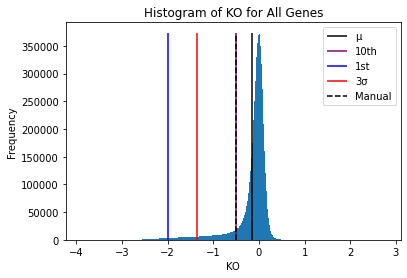

In [19]:
# Histogram of KO values.
h = plt.hist(omics['KO'], bins=1000)

# Add thresholds
plt.vlines(np.mean(omics['KO']), 0, max(h[0]), color='black', label='μ')
plt.vlines(omics['KO'].quantile(0.1), 0, max(h[0]), color='purple', label='10th')
plt.vlines(omics['KO'].quantile(0.01), 0, max(h[0]), color='blue', label='1st')
plt.vlines(np.mean(omics['KO']) - np.std(omics['KO'])*3, 0, max(h[0]), color='red', label='3σ')
plt.vlines(-0.5, 0, max(h[0]), color='black', linestyles='dashed', label='Manual')
plt.legend()
plt.title('Histogram of KO for All Genes')
plt.xlabel('KO')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

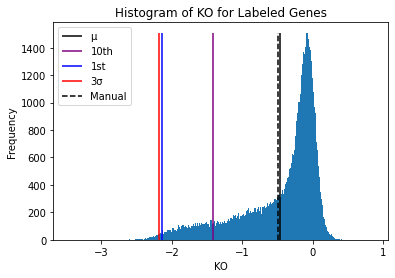

In [20]:
# Histogram of KO values for manually selected genes.
h = plt.hist(ec['KO'], bins=1000)

# Add thresholds
plt.vlines(np.mean(ec['KO']), 0, max(h[0]), color='black', label='μ')
plt.vlines(ec['KO'].quantile(0.1), 0, max(h[0]), color='purple', label='10th')
plt.vlines(ec['KO'].quantile(0.01), 0, max(h[0]), color='blue', label='1st')
plt.vlines(np.mean(ec['KO']) - np.std(ec['KO'])*3, 0, max(h[0]), color='red', label='3σ')
plt.vlines(-0.5, 0, max(h[0]), color='black', linestyles='dashed', label='Manual')
plt.legend()
plt.title('Histogram of KO for Labeled Genes')
plt.xlabel('KO')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

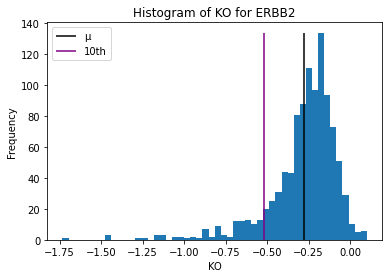

In [26]:
# Histogram of KO values for manually selected genes.
h = plt.hist(erbb2['KO'], bins=50)

# Add thresholds
plt.vlines(np.mean(erbb2['KO']), 0, max(h[0]), color='black', label='μ')
plt.vlines(erbb2['KO'].quantile(0.1), 0, max(h[0]), color='purple', label='10th')
plt.legend()
plt.title('Histogram of KO for ERBB2')
plt.xlabel('KO')
plt.ylabel('Frequency')

10th percentile gets sufficiently low while not filtering out too many data points.

### Trying Different Statistical Labeling Schemes

We'll try labeling based on these statistics:
* KO 10th, CN 90th percentile
* KO 1st, CN 99th percentile
* KO and CN 3σ
* KO and CN 5σ
* KO 10th percentile, CN 3σ

In [12]:
# Functions for labeling according to these statistical limits and a mix of 3σ for CN and 10th percentile for KO.

def label_perc90(grp):
    cn_lim = grp['CN'].quantile(0.9)
    ko_lim = grp['KO'].quantile(0.1)
    grp['90th'] = np.select([
                            ((grp['CN'] > cn_lim) & (grp['KO'] < ko_lim)),
                            ((grp['CN'] < cn_lim) & (grp['KO'] > ko_lim)),
                            ((grp['CN'] < cn_lim) & (grp['KO'] < ko_lim))
                           ],
                           [1, 0, 2], default=3)
    return grp


def label_perc99(grp):
    cn_lim = grp['CN'].quantile(0.99)
    ko_lim = grp['KO'].quantile(0.01)
    grp['99th'] = np.select([
                            ((grp['CN'] > cn_lim) & (grp['KO'] < ko_lim)),
                            ((grp['CN'] < cn_lim) & (grp['KO'] > ko_lim)),
                            ((grp['CN'] < cn_lim) & (grp['KO'] < ko_lim))
                           ],
                           [1, 0, 2], default=3)
    return grp


def label_sigma3(grp):
    cn_lim = np.mean(grp['CN']) + np.std(grp['CN'])*3
    ko_lim = np.mean(grp['KO']) - np.std(grp['KO'])*3
    grp['Sigma3'] = np.select([
                            ((grp['CN'] > cn_lim) & (grp['KO'] < ko_lim)),
                            ((grp['CN'] < cn_lim) & (grp['KO'] > ko_lim)),
                            ((grp['CN'] < cn_lim) & (grp['KO'] < ko_lim))
                           ],
                           [1, 0, 2], default=3)
    return grp


def label_sigma5(grp):
    cn_lim = np.mean(grp['CN']) + np.std(grp['CN'])*5
    ko_lim = np.mean(grp['KO']) - np.std(grp['KO'])*5
    grp['Sigma5'] = np.select([
                            ((grp['CN'] > cn_lim) & (grp['KO'] < ko_lim)),
                            ((grp['CN'] < cn_lim) & (grp['KO'] > ko_lim)),
                            ((grp['CN'] < cn_lim) & (grp['KO'] < ko_lim))
                           ],
                           [1, 0, 2], default=3)
    return grp


def label_mix(grp):
    cn_lim = np.mean(grp['CN']) + np.std(grp['CN'])*5
    ko_lim = grp['KO'].quantile(0.1)
    grp['Mix'] = np.select([
                            ((grp['CN'] > cn_lim) & (grp['KO'] < ko_lim)),
                            ((grp['CN'] < cn_lim) & (grp['KO'] > ko_lim)),
                            ((grp['CN'] < cn_lim) & (grp['KO'] < ko_lim))
                           ],
                           [1, 0, 2], default=3)
    return grp

    
omics = omics.groupby('Gene').apply(label_perc90)
omics = omics.groupby('Gene').apply(label_perc99)
omics = omics.groupby('Gene').apply(label_sigma3)
omics = omics.groupby('Gene').apply(label_sigma5)
omics = omics.groupby('Gene').apply(label_mix)

omics

,DepMap_ID,CCLE_Name,Gene,CN,KO,Manual,90th,99th,Sigma3,Sigma5,Mix
0,ACH-000001,NIHOVCAR3_OVARY,SAMD11,1.465784,0.079212,0,3,3,0,0,0
1,ACH-000004,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SAMD11,1.372718,0.120627,0,3,0,0,0,0
2,ACH-000005,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SAMD11,1.323179,-0.044225,0,3,0,0,0,0
3,ACH-000007,LS513_LARGE_INTESTINE,SAMD11,0.964563,0.148729,0,0,0,0,0,0
4,ACH-000009,C2BBE1_LARGE_INTESTINE,SAMD11,0.823542,-0.166797,0,2,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...
18089990,ACH-002461,RVH421_SKIN_FV1_RESISTANT,IL9R,0.688248,-0.253670,0,0,0,0,0,0
18089991,ACH-002465,RPE1SS119_ENGINEERED,IL9R,1.060044,-0.113279,0,3,0,0,0,0
18089992,ACH-002508,WM3211_SKIN,IL9R,1.143795,-0.116946,0,3,0,0,0,0
18089993,ACH-002510,M040416_SKIN,IL9R,0.644780,-0.044787,0,0,0,0,0,0


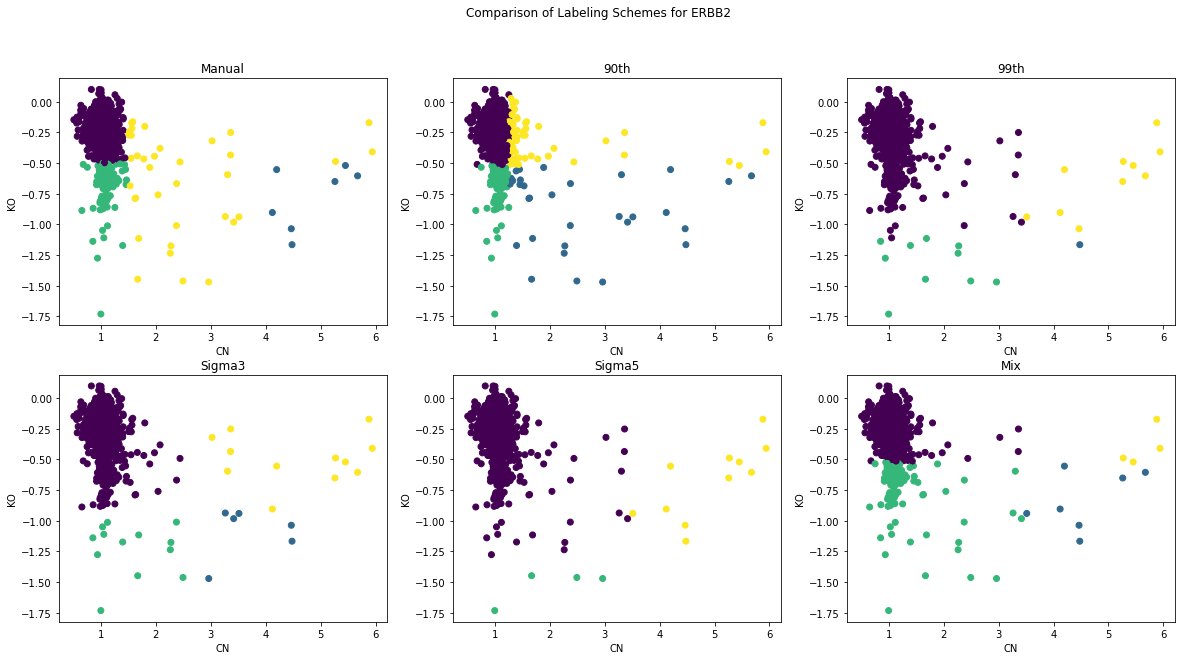

In [23]:
# Results on ERBB2

erbb2 = omics[omics['Gene']=='ERBB2']

fig, axs = plt.subplots(2, 3, figsize=(20,10))
fig.suptitle('Comparison of Labeling Schemes for ERBB2')
# plt.setp(axs, xlim=(0,8), ylim=(-4,3))
axs[0][0].scatter(erbb2['CN'], erbb2['KO'], c=erbb2['Manual'])
axs[0][1].scatter(erbb2['CN'], erbb2['KO'], c=erbb2['90th'])
axs[0][2].scatter(erbb2['CN'], erbb2['KO'], c=erbb2['99th'])
axs[1][0].scatter(erbb2['CN'], erbb2['KO'], c=erbb2['Sigma3'])
axs[1][1].scatter(erbb2['CN'], erbb2['KO'], c=erbb2['Sigma5'])
axs[1][2].scatter(erbb2['CN'], erbb2['KO'], c=erbb2['Mix'])

axs[0][0].set_title('Manual')
axs[0][1].set_title('90th')
axs[0][2].set_title('99th')
axs[1][0].set_title('Sigma3')
axs[1][1].set_title('Sigma5')
axs[1][2].set_title('Mix')

for ax in axs.ravel():
    ax.set_xlabel('CN')
    ax.set_ylabel('KO')

Mixed version gives the result closest to our manual selection.

Let's see what it looks like for all genes.

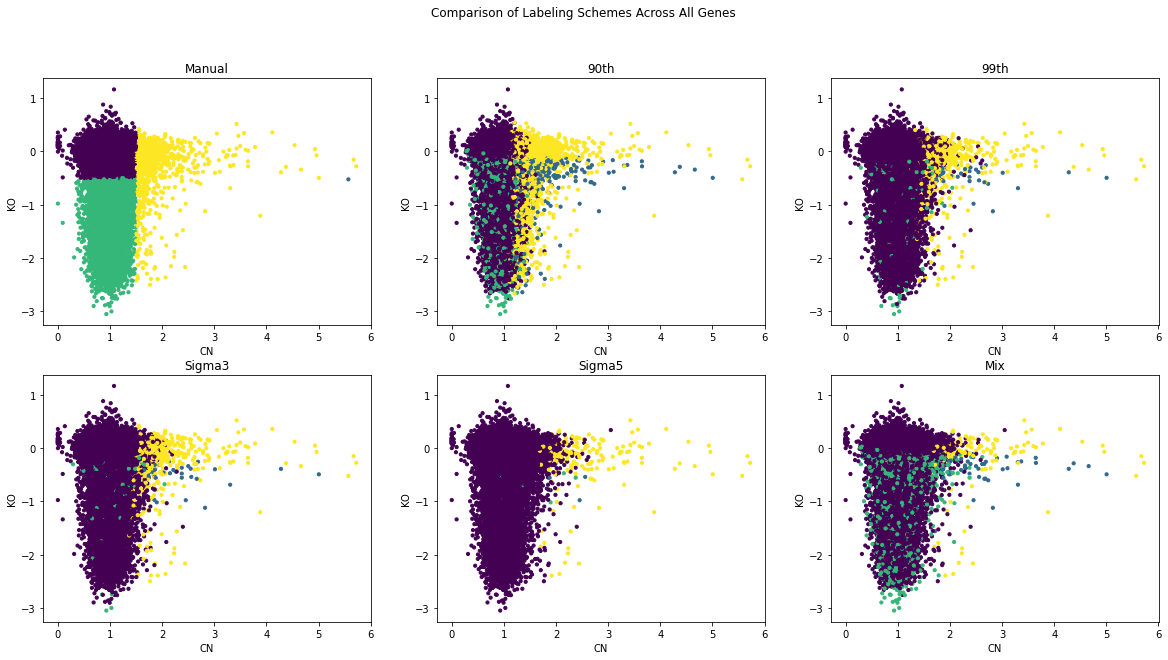

In [34]:
# Looking at all genes at once.

import random

# Subsample to make it easier to plot.
omics_sample = omics.sample(100000)

fig, axs = plt.subplots(2, 3, figsize=(20,10))
fig.suptitle('Comparison of Labeling Schemes Across All Genes')
# plt.setp(axs, xlim=(0,8), ylim=(-4,3))
axs[0][0].scatter(omics_sample['CN'], omics_sample['KO'], c=omics_sample['Manual'], s=10)
axs[0][1].scatter(omics_sample['CN'], omics_sample['KO'], c=omics_sample['90th'], s=10)
axs[0][2].scatter(omics_sample['CN'], omics_sample['KO'], c=omics_sample['99th'], s=10)
axs[1][0].scatter(omics_sample['CN'], omics_sample['KO'], c=omics_sample['Sigma3'], s=10)
axs[1][1].scatter(omics_sample['CN'], omics_sample['KO'], c=omics_sample['Sigma5'], s=10)
axs[1][2].scatter(omics_sample['CN'], omics_sample['KO'], c=omics_sample['Mix'], s=10)

axs[0][0].set_title('Manual')
axs[0][1].set_title('90th')
axs[0][2].set_title('99th')
axs[1][0].set_title('Sigma3')
axs[1][1].set_title('Sigma5')
axs[1][2].set_title('Mix')

for ax in axs.ravel():
    ax.set_xlabel('CN')
    ax.set_ylabel('KO')

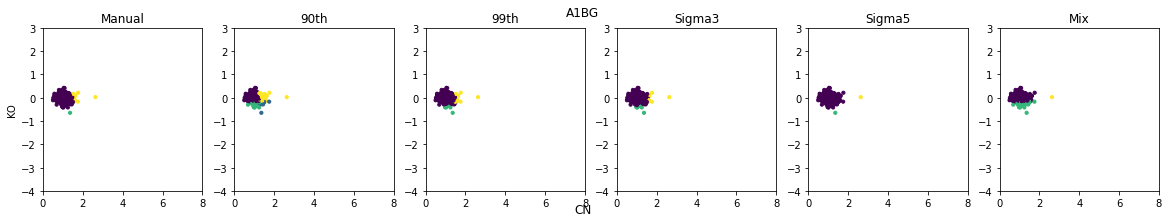

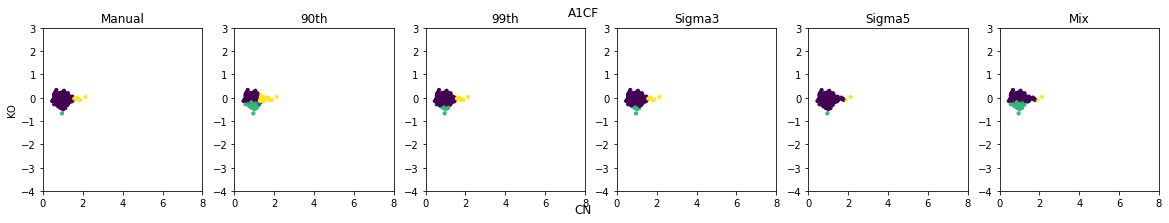

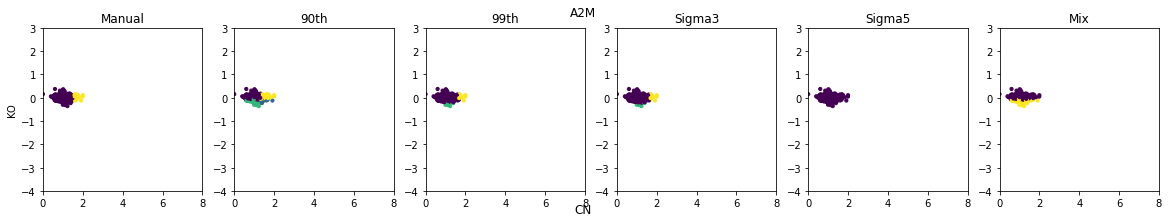

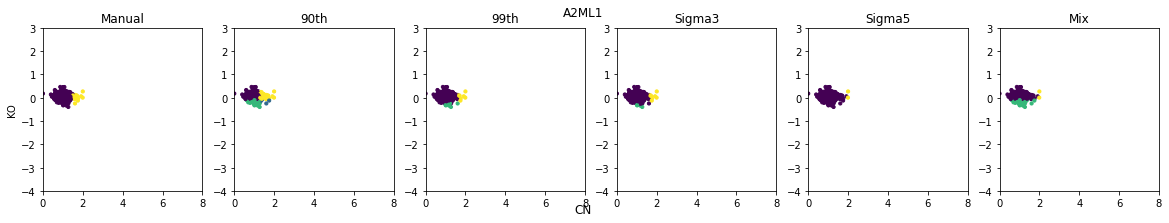

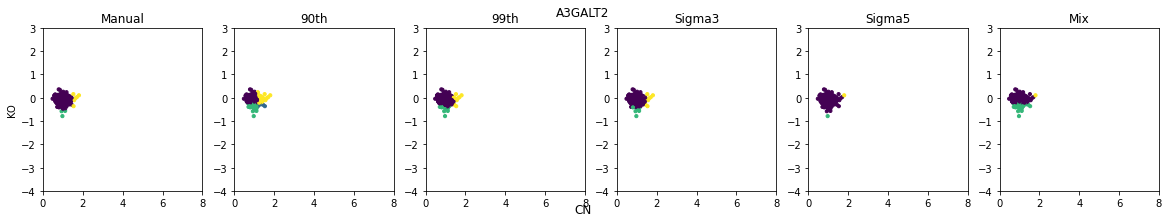

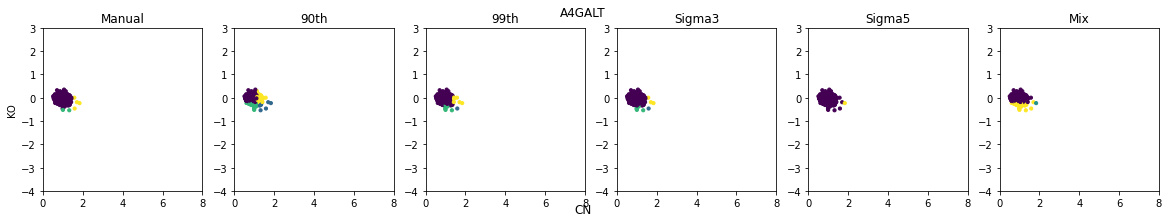

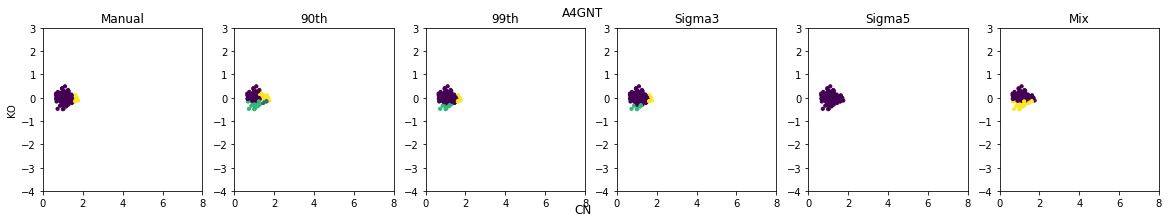

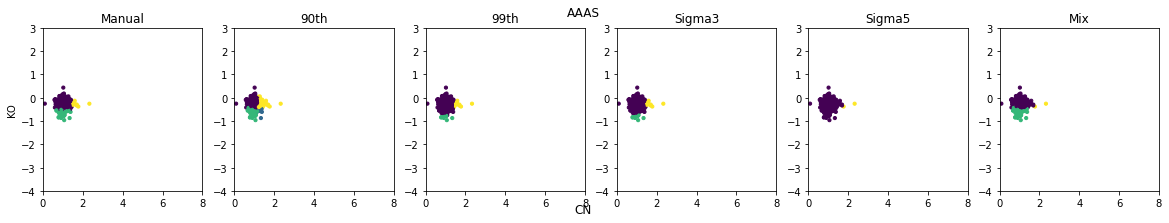

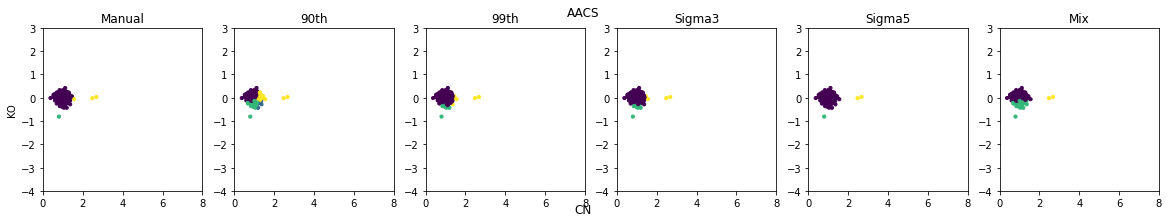

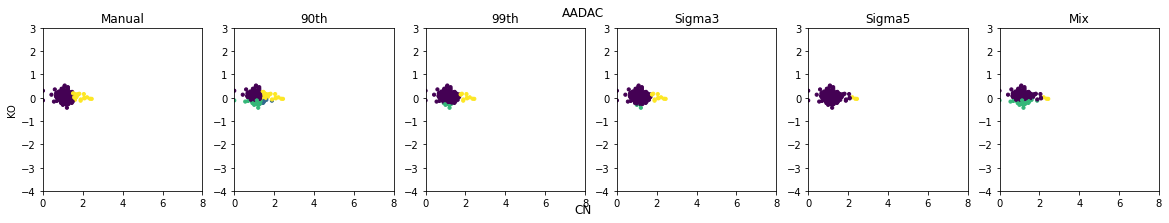

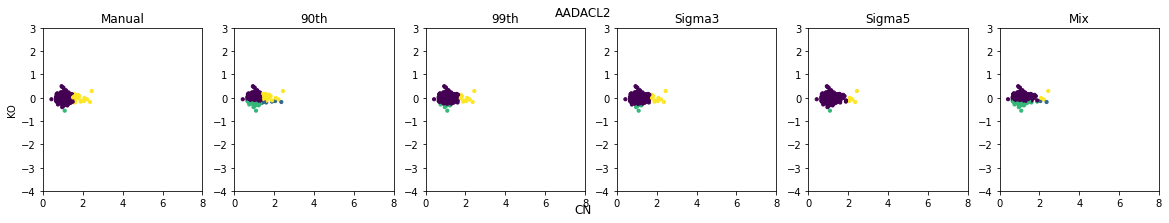

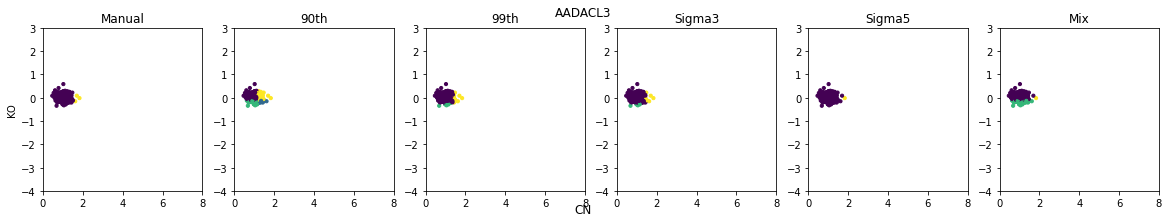

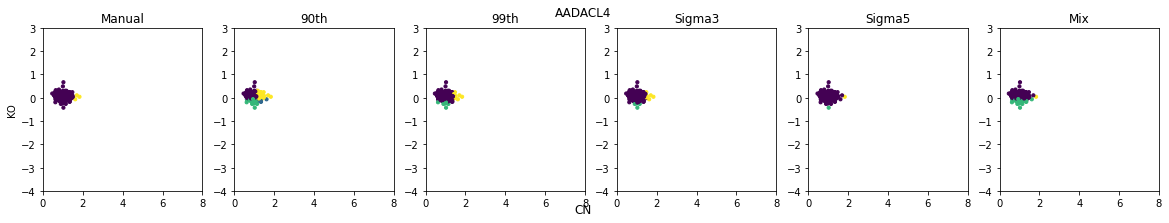

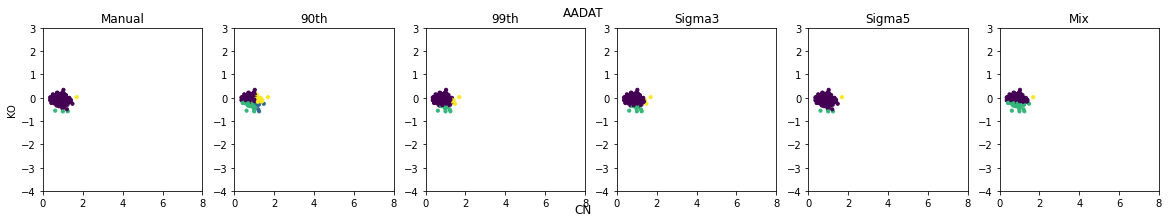

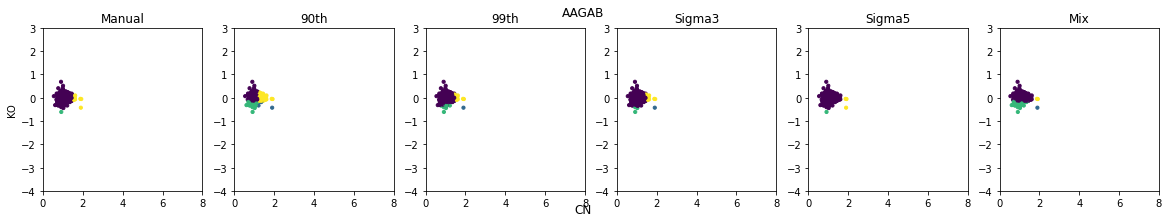

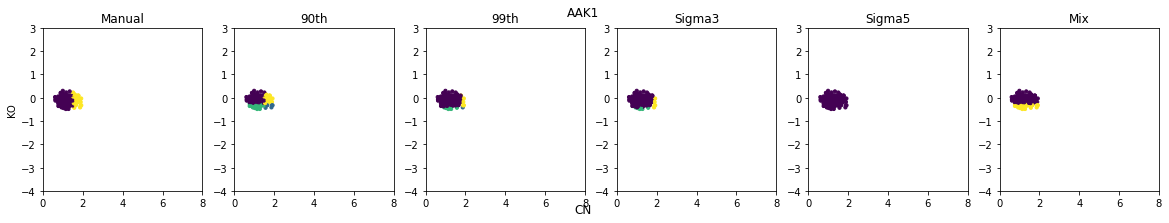

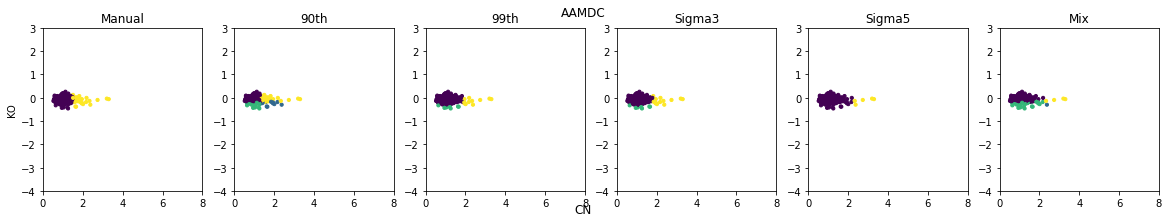

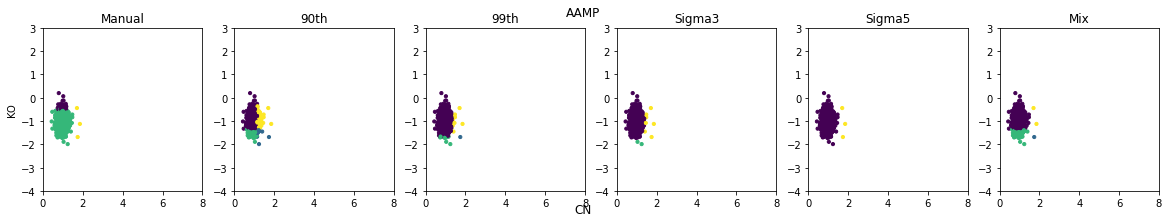

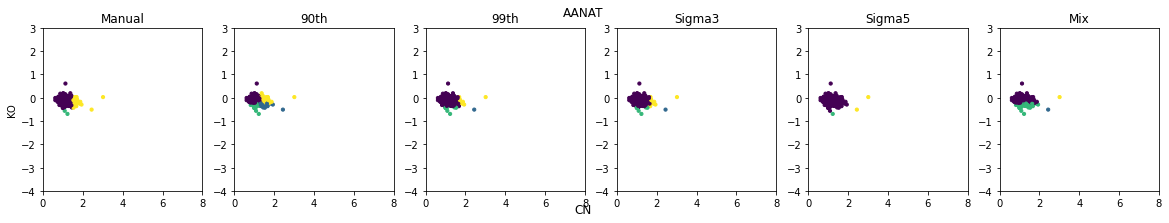

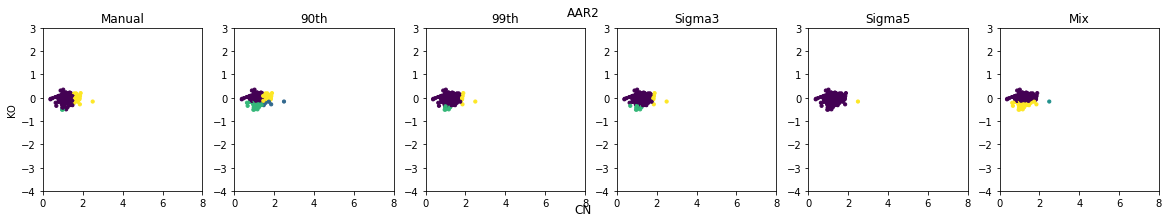

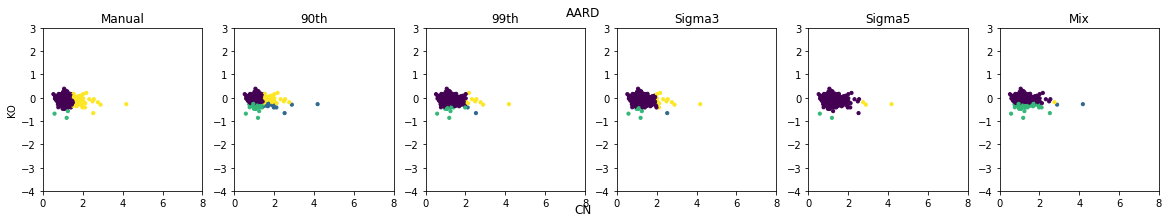

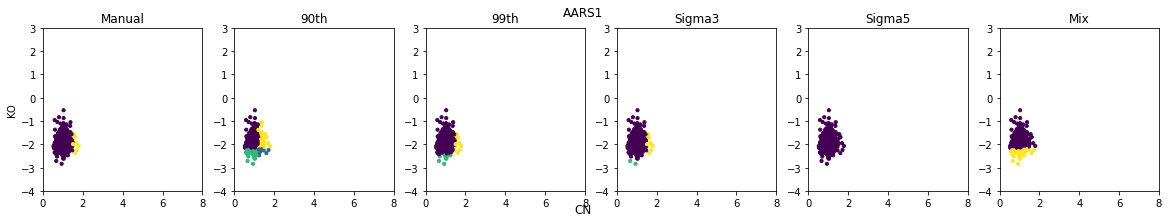

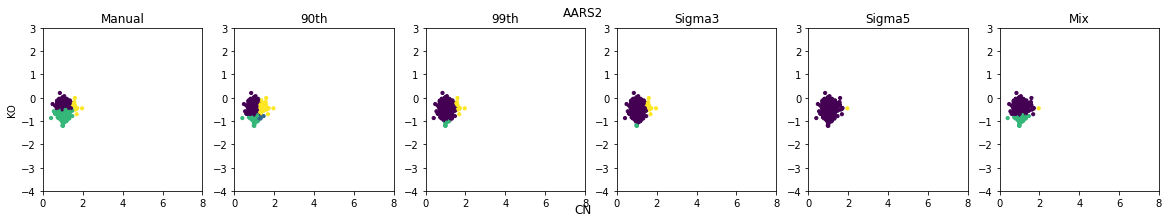

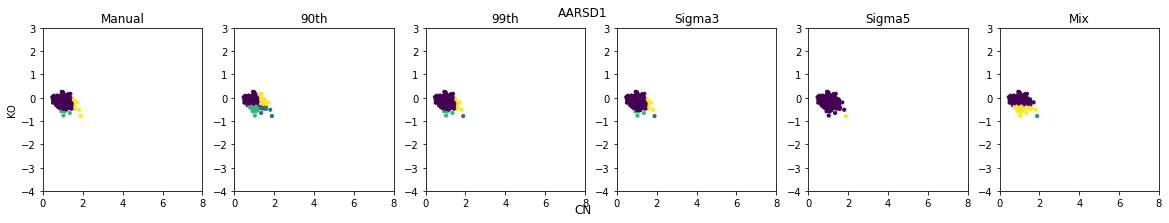

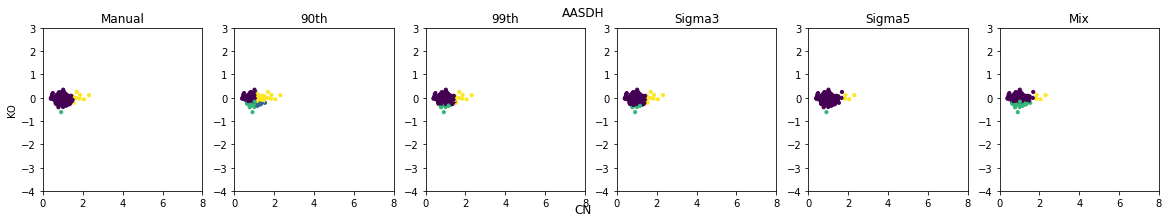

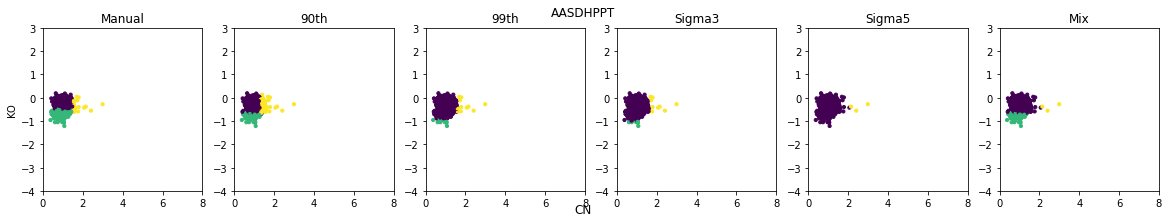

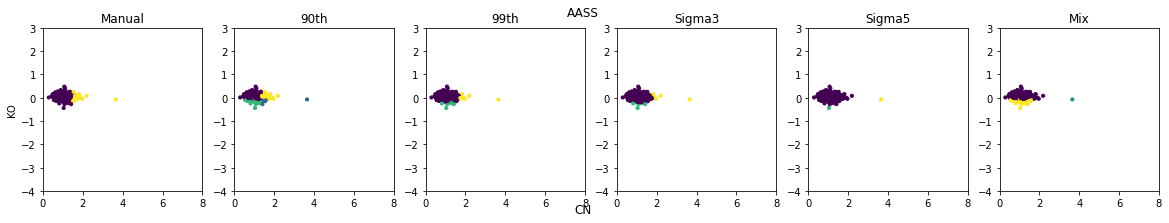

KeyboardInterrupt: 

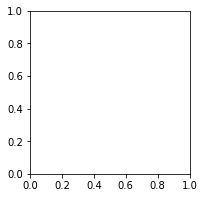

In [43]:
# Looking at all genes one by one.

for i, j in omics.groupby('Gene'):
    fig, axs = plt.subplots(1, 6, figsize=(20,3))
    fig.suptitle(i)
    fig.supxlabel('CN')
    plt.setp(axs, xlim=(0,8), ylim=(-4,3))
    axs[0].scatter(j['CN'], j['KO'], c=j['Manual'], s=10)
    axs[1].scatter(j['CN'], j['KO'], c=j['90th'], s=10)
    axs[2].scatter(j['CN'], j['KO'], c=j['99th'], s=10)
    axs[3].scatter(j['CN'], j['KO'], c=j['Sigma3'], s=10)
    axs[4].scatter(j['CN'], j['KO'], c=j['Sigma5'], s=10)
    axs[5].scatter(j['CN'], j['KO'], c=j['Mix'], s=10)

    axs[1].set_title('90th')
    axs[2].set_title('99th')
    axs[3].set_title('Sigma3')
    axs[4].set_title('Sigma5')
    axs[5].set_title('Mix')
    axs[0].set_title('Manual')
    
    axs[0].set_ylabel('KO')

    plt.show()

Mixed labeling scheme gives the closest results to what we want.

Text(0, 0.5, 'KO')

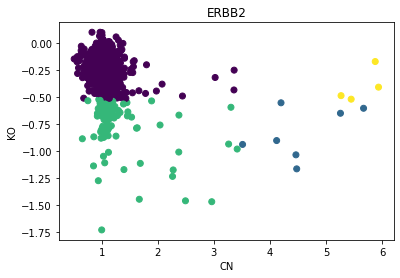

In [29]:
plt.scatter(erbb2['CN'], erbb2['KO'], c=erbb2['Mix'])
plt.title('ERBB2')
plt.xlabel('CN')
plt.ylabel('KO')

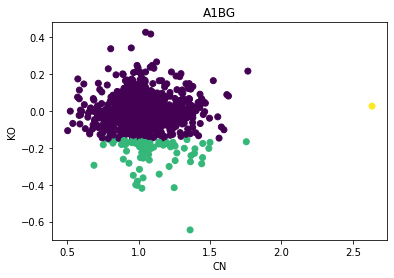

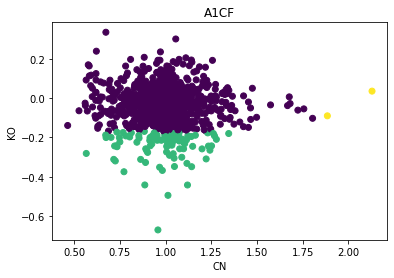

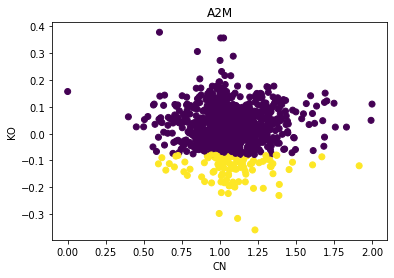

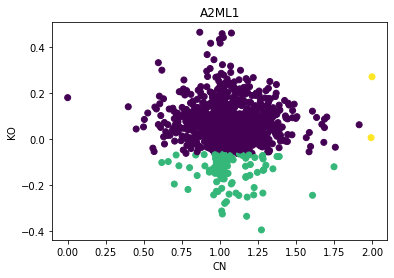

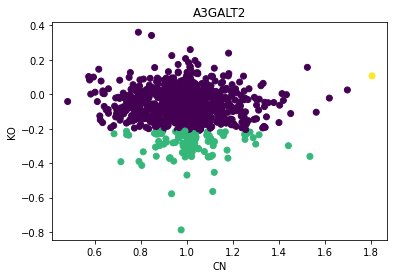

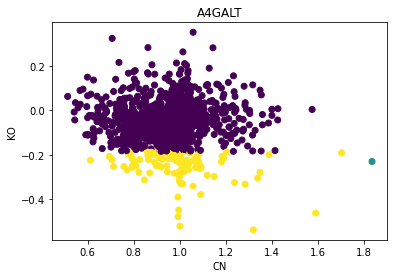

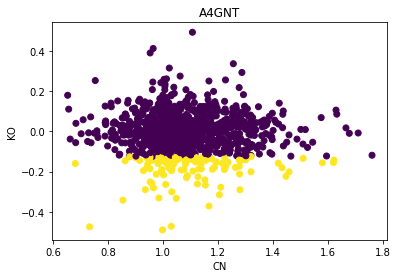

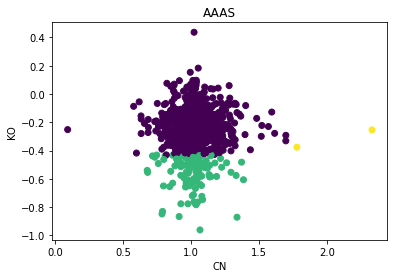

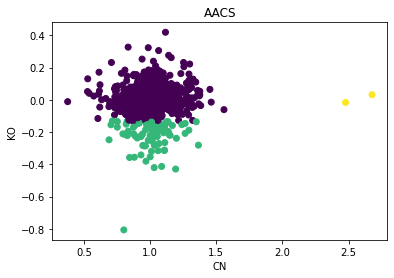

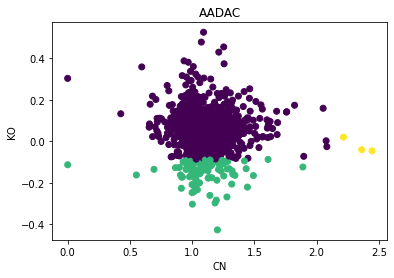

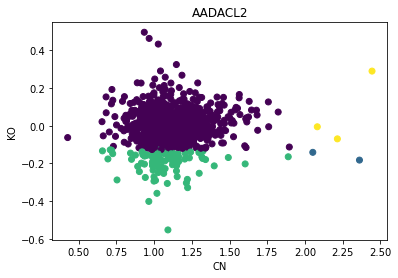

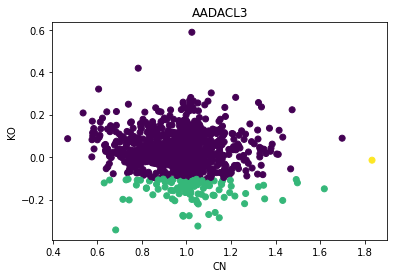

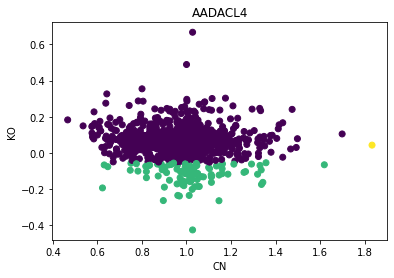

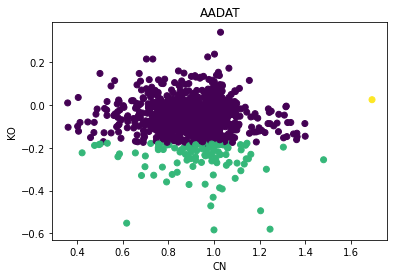

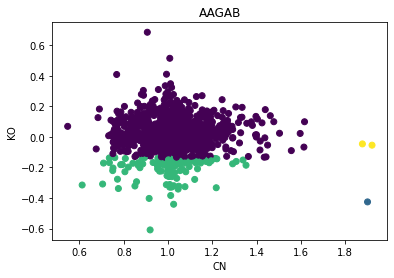

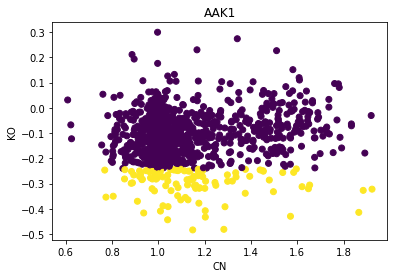

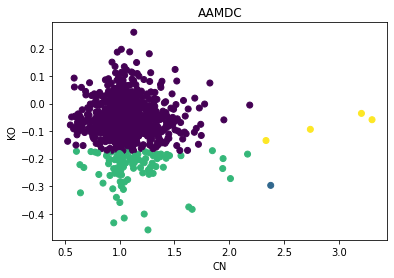

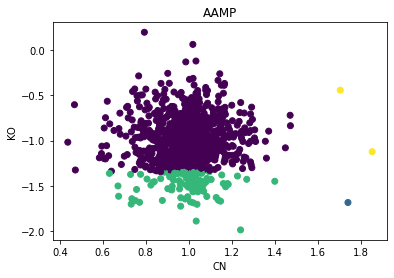

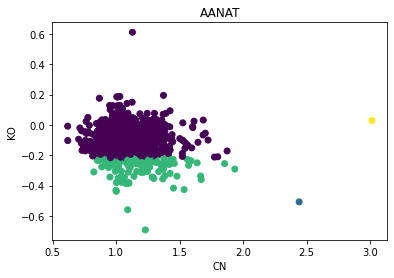

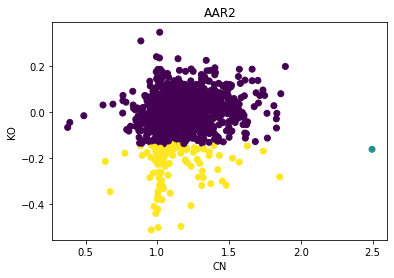

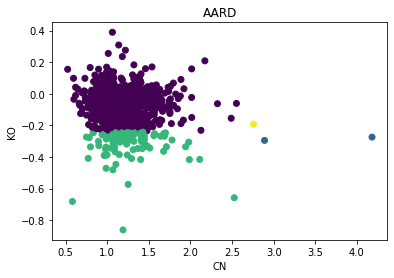

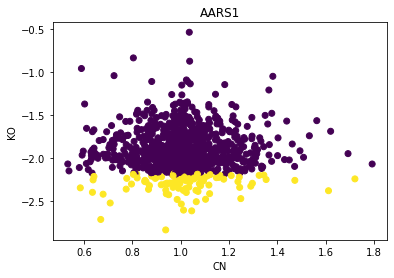

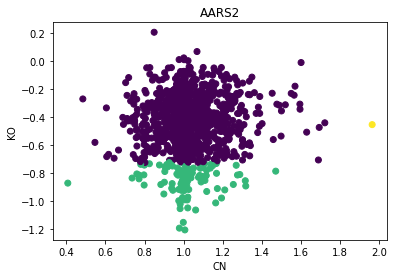

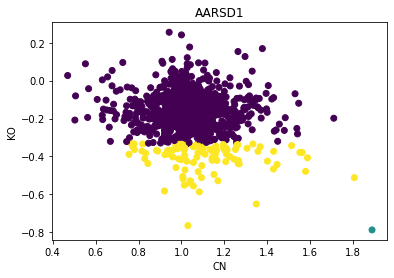

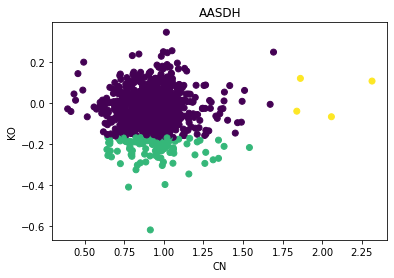

KeyboardInterrupt: 

In [28]:
# Plot all genes

for gene, df in omics.groupby('Gene'):
    plt.scatter(df['CN'], df['KO'], c=df['Mix'])
    plt.xlabel('CN')
    plt.ylabel('KO')
    plt.title(gene)
    plt.show()

In [25]:
# We will use mixed labeling scheme for further analysis.

ecm = omics[['DepMap_ID', 'CCLE_Name', 'Gene', 'CN', 'KO', 'Mix']]
ecm

,DepMap_ID,CCLE_Name,Gene,CN,KO,Mix
0,ACH-000001,NIHOVCAR3_OVARY,SAMD11,1.465784,0.079212,0
1,ACH-000004,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SAMD11,1.372718,0.120627,0
2,ACH-000005,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SAMD11,1.323179,-0.044225,0
3,ACH-000007,LS513_LARGE_INTESTINE,SAMD11,0.964563,0.148729,0
4,ACH-000009,C2BBE1_LARGE_INTESTINE,SAMD11,0.823542,-0.166797,2
...,...,...,...,...,...,...
18089990,ACH-002461,RVH421_SKIN_FV1_RESISTANT,IL9R,0.688248,-0.253670,0
18089991,ACH-002465,RPE1SS119_ENGINEERED,IL9R,1.060044,-0.113279,0
18089992,ACH-002508,WM3211_SKIN,IL9R,1.143795,-0.116946,0
18089993,ACH-002510,M040416_SKIN,IL9R,0.644780,-0.044787,0


## Check Clusters

We need a way to measure the separation of our clusters. One way to do this is to calculate the distance between the centers (centroids) of the clusters. We will check the centroid distance between the main cluster that contains the average data points and the cluster we expect to be related to ecDNA.

In [73]:
# Calculate centroids and distances

def centroids_distances(limit):
    centroids = omics.groupby(['Gene', limit])[['CN', 'KO']].mean()
    distances = {}
    for i, j in centroids.groupby('Gene'):
        if all(labels in j.index.get_level_values(limit) for labels in (0,1)):
            j = j.reset_index(level=0, drop=True)
            distances[i] = ((j.loc[1] - j.loc[0])**2).sum()**0.5   
    return centroids, distances
        
        
manual_centroids, manual_distances = centroids_distances('Manual')
perc90_centroids, perc90_distances = centroids_distances('90th')
perc99_centroids, perc99_distances = centroids_distances('99th')
sigma3_centroids, sigma3_distances = centroids_distances('Sigma3')
sigma5_centroids, sigma5_distances = centroids_distances('Sigma5')
mix_centroids, mix_distances = centroids_distances('Mix')

centroid_distances = pd.DataFrame.from_dict([manual_distances, perc90_distances, perc99_distances, sigma3_distances, sigma5_distances, mix_distances]).transpose()
centroid_distances.columns = ['Manual', '90th', '99th', 'Sigma3', 'Sigma5', 'Mix']

centroid_distances

# # Save centroid distances
# centroid_distances.to_pickle('centroid_distances.pkl')

,Manual,90th,99th,Sigma3,Sigma5,Mix
ADAMTS20,3.258169,1.287935,3.221678,3.218538,3.214524,2.873531
ADTRP,3.485474,0.790198,2.421672,2.416474,3.478631,2.717985
AGAP2,3.498338,1.455294,3.451133,2.969945,2.999645,3.401297
AIFM3,3.519631,0.868034,2.286924,1.701456,NaN,2.717475
ALK,3.394456,0.528031,3.397082,3.394442,3.391005,3.403479
...,...,...,...,...,...,...
ZYG11A,NaN,0.406487,0.618345,0.616652,NaN,NaN
ZYG11B,NaN,0.413611,NaN,NaN,NaN,NaN
ZYX,NaN,0.479288,0.789308,0.785463,NaN,NaN
ZZEF1,NaN,0.387873,NaN,NaN,NaN,NaN


In [17]:
# Average centroid distance

centroid_distances.mean()

Manual    3.530263
90th      0.509108
99th      1.055230
Sigma3    1.171152
Sigma5    1.989316
Mix       1.473047
dtype: float64

The average separation of manual labeling is much higher than the others with 3.53. This is because it has a hard threshold on high values whereas the others might have low threshold depending on the gene. 5σ has the best separation but it filters out too many data points.

Mixed labeling comes right after it and performs better than others with 1.47 average. We can use the separation score of each gene to filter out the ones that fall too close to the main cluser of data points.

Text(0, 0.5, 'Frequency')

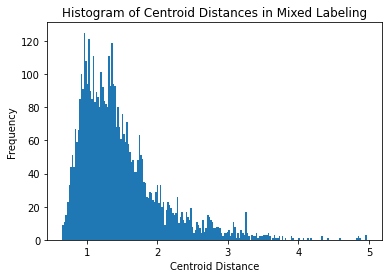

In [40]:
plt.hist(centroid_distances['Mix'], bins=200)
plt.title('Histogram of Centroid Distances in Mixed Labeling')
plt.xlabel('Centroid Distance')
plt.ylabel('Frequency')

We will use the groove at 2.5 to filter out genes with low separation.

In [26]:
# Filter out data points not labled to be ecDNA related
ecm = ecm[ecm['Mix']==1]

# Filter out low separation genes
ecm = ecm.merge(centroid_distances[centroid_distances['Mix']>2.5]['Mix'],
                left_on='Gene', right_index=True, suffixes=['','_Dist'])

# We will also need chromosome data
ecm = ecm.merge(chroms, on='Gene', how='left')

ecm

,DepMap_ID,CCLE_Name,Gene,CN,KO,Mix,Mix_Dist,Chromosome
0,ACH-000332,YAPC_PANCREAS,PANK4,3.521278,-0.490405,1,2.597722,1
1,ACH-000332,YAPC_PANCREAS,TNFRSF14,3.521278,-0.191987,1,2.553395,1
2,ACH-000332,YAPC_PANCREAS,MMEL1,3.521278,-0.370459,1,2.558665,1
3,ACH-000332,YAPC_PANCREAS,TTC34,3.521278,-0.358517,1,2.597431,1
4,ACH-000332,YAPC_PANCREAS,ACTRT2,3.521278,-0.226640,1,2.561954,1
...,...,...,...,...,...,...,...,...
703,ACH-000181,SCC9_UPPER_AERODIGESTIVE_TRACT,GNE,3.587446,-0.337951,1,2.625062,9
704,ACH-001794,93T449_SOFT_TISSUE,SLC28A3,3.913869,-0.177683,1,2.754024,9
705,ACH-001795,94T778_SOFT_TISSUE,SLC28A3,3.572041,-0.353092,1,2.754024,9
706,ACH-001228,UPCISCC152_UPPER_AERODIGESTIVE_TRACT,FOXE1,3.785417,-0.277433,1,2.770812,9


### Merge chromosome data 

In [8]:
ecm = omics2.merge(genome[['#chrom','symbol']], left_on='Gene', right_on='symbol')
ecm.head(2)

,DepMap_ID,CCLE_Name,Gene,CN,GE,Manual,cell_CN_999,cell_GE_97,gene_CN_99,gene_GE_97,N_cell_CN_999,N_cell_GE_97,N_gene_CN_99,N_gene_GE_97,cell_CN_diff,cell_CN_Q,cell_GE_diff,cell_GE_Q,gene_CN_diff,gene_CN_Q,gene_gene_diff,gene_gene_Q,Manualv2,#chrom,symbol
0,ACH-000001,NIHOVCAR3_OVARY,OR4F5,1.465784,0.0,2,3.205374,7.593789,1.893039,0.028569,4,575,14,30,-1.739589,-0.434897,-7.593789,-0.013207,-0.427255,-0.030518,-0.028569,-0.000952,2,chr1,OR4F5
1,ACH-000002,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,OR4F5,1.041792,0.0,2,1.917845,7.131535,1.893039,0.028569,20,575,14,30,-0.876054,-0.043803,-7.131535,-0.012403,-0.851247,-0.060803,-0.028569,-0.000952,2,chr1,OR4F5


## Chromosomes

In [107]:
# Different chromosomes found to contain ecDNA related genes in each cell line
chrom_prevalence = []
for cell_line in scl:
    #print(cell_line, ecm[ecm['CCLE_Name']==cell_line]['Chromosome'].dropna().unique())
    chrom_prevalence += ecm2[ecm2['CCLE_Name']==cell_line]['Chromosome'].dropna().tolist()

Text(0, 0.5, 'Number of Gene Predictions')

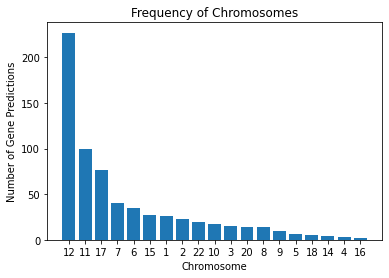

In [42]:
## Prevalence of Chromosomes

plt.bar(ecm2['Chromosome'].value_counts().index, ecm2['Chromosome'].value_counts())
plt.title('Frequency of Chromosomes')
plt.xlabel('Chromosome')
plt.ylabel('Number of Gene Predictions')


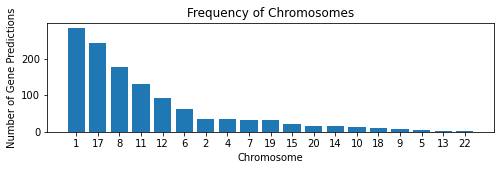

In [151]:
## Prevalence of Chromosomes
plt.figure(figsize=(8,2))

plt.bar(ecm2[ecm2.Manualv2.isin([1,3])]['Chromosome'].value_counts().index, ecm2[ecm2.Manualv2.isin([1,3])]['Chromosome'].value_counts())
plt.title('Frequency of Chromosomes')
plt.xlabel('Chromosome')
plt.ylabel('Number of Gene Predictions')
plt.savefig("../CCLE_analysis/figures_for_ECDB_paper/Freq_chromosomes.svg", format='svg')

In [109]:
ecm2[(ecm2.Manualv2==1)&(ecm2.Chromosome=='17')]

,DepMap_ID,CCLE_Name,Gene,CN,GE,Manual,cell_CN_999,cell_GE_97,gene_CN_99,gene_GE_97,N_cell_CN_999,N_cell_GE_97,N_gene_CN_99,N_gene_GE_97,cell_CN_diff,cell_CN_Q,cell_GE_diff,cell_GE_Q,gene_CN_diff,gene_CN_Q,gene_gene_diff,gene_gene_Q,Manualv2,#chrom,symbol,Chromosome
10862545,ACH-000117,EFM192A_BREAST,ELAC2,3.108308,8.602736,0,3.921662,7.565485,1.394553,6.426751,1,575,14,42,-0.813354,-0.813354,1.037251,0.001804,1.713755,0.122411,2.175985,0.051809,1,chr17,ELAC2,17
11268473,ACH-000117,EFM192A_BREAST,CISD3,3.136409,8.231365,0,3.921662,7.565485,1.790103,5.685912,1,575,14,42,-0.785254,-0.785254,0.665880,0.001158,1.346306,0.096165,2.545453,0.060606,1,chr17,CISD3,17
11268474,ACH-000117,EFM192A_BREAST,CISD3,3.136409,8.231365,0,3.921662,7.565485,1.790103,5.685912,1,575,14,42,-0.785254,-0.785254,0.665880,0.001158,1.346306,0.096165,2.545453,0.060606,1,chr17_KI270857v1_alt,CISD3,17
11271215,ACH-000117,EFM192A_BREAST,PCGF2,3.136409,7.575691,2,3.921662,7.565485,1.790103,5.734651,1,575,14,42,-0.785254,-0.785254,0.010205,0.000018,1.346306,0.096165,1.841039,0.043834,1,chr17,PCGF2,17
11271216,ACH-000117,EFM192A_BREAST,PCGF2,3.136409,7.575691,2,3.921662,7.565485,1.790103,5.734651,1,575,14,42,-0.785254,-0.785254,0.010205,0.000018,1.346306,0.096165,1.841039,0.043834,1,chr17_KI270857v1_alt,PCGF2,17
11273957,ACH-000117,EFM192A_BREAST,PSMB3,3.136409,10.456457,0,3.921662,7.565485,1.790103,9.120810,1,575,14,42,-0.785254,-0.785254,2.890972,0.005028,1.346306,0.096165,1.335647,0.031801,1,chr17,PSMB3,17
11273958,ACH-000117,EFM192A_BREAST,PSMB3,3.136409,10.456457,0,3.921662,7.565485,1.790103,9.120810,1,575,14,42,-0.785254,-0.785254,2.890972,0.005028,1.346306,0.096165,1.335647,0.031801,1,chr17_KI270857v1_alt,PSMB3,17
11284813,ACH-000117,EFM192A_BREAST,RPL23,3.136409,12.954760,0,3.921662,7.565485,1.790103,12.192307,1,575,14,42,-0.785254,-0.785254,5.389275,0.009373,1.346306,0.096165,0.762452,0.018154,1,chr17,RPL23,17
11286184,ACH-000117,EFM192A_BREAST,LASP1,3.136409,8.615446,0,3.921662,7.565485,1.790103,8.204961,1,575,14,42,-0.785254,-0.785254,1.049961,0.001826,1.346306,0.096165,0.410484,0.009773,1,chr17,LASP1,17
11292942,ACH-000017,SKBR3_BREAST,RPL19,3.512129,14.607561,0,3.512129,7.593942,2.196297,12.543024,7,575,14,42,0.000000,0.000000,7.013620,0.012198,1.315832,0.093988,2.064538,0.049156,1,chr17,RPL19,17


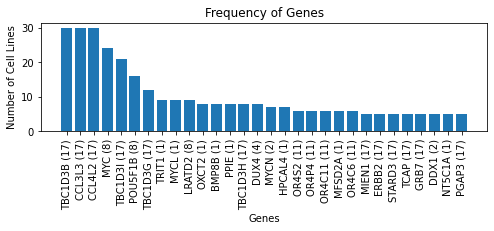

In [152]:
## Prevalence of Genes

plt.figure(figsize=(8,2))
gene_prevalences = ecm2[ecm2.Manualv2.isin([1,3])]['Gene'].value_counts()
gene_prevalences.index = [f"{i} ({ecm2[ecm2.Manualv2.isin([1,3])][['Gene','Chromosome']].drop_duplicates(ignore_index=True).set_index('Gene').loc[i, 'Chromosome']})" for i in gene_prevalences.index]

plt.bar(gene_prevalences.index[:30], gene_prevalences[:30])
plt.xticks(rotation = 90)
plt.title('Frequency of Genes')
plt.xlabel('Genes')
plt.ylabel('Number of Cell Lines')
plt.savefig("../CCLE_analysis/figures_for_ECDB_paper/Freq_genes.svg", format='svg')

In [37]:
ecm2[ecm2.Manualv2.isin([1,3])].groupby('Chromosome').size().to_dict()

{1: 283,
 2: 35,
 4: 34,
 5: 4,
 6: 62,
 7: 33,
 8: 177,
 9: 9,
 10: 12,
 11: 132,
 12: 93,
 13: 3,
 14: 17,
 15: 22,
 17: 242,
 18: 11,
 19: 31,
 20: 17,
 22: 2}

In [38]:
ecm2[ecm2.Manualv2.isin([1,3])].groupby('Chromosome')['Gene'].unique().apply(len).to_dict()

{1: 153,
 2: 21,
 4: 27,
 5: 4,
 6: 57,
 7: 29,
 8: 87,
 9: 9,
 10: 8,
 11: 88,
 12: 75,
 13: 3,
 14: 17,
 15: 7,
 17: 60,
 18: 11,
 19: 25,
 20: 17,
 22: 1}

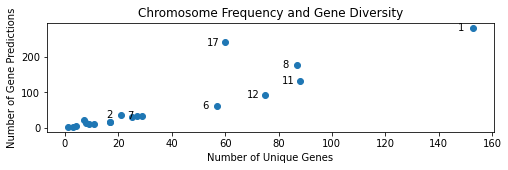

In [19]:
## Prevalence of Chromosomes
plt.figure(figsize=(8,2))

chrom_freq = ecm2[ecm2.Manualv2.isin([1,3])].groupby('Chromosome').size().to_dict()
chrom_diversity = ecm2[ecm2.Manualv2.isin([1,3])].groupby('Chromosome')['Gene'].unique().apply(len).to_dict()

plt.scatter(chrom_diversity.values(), chrom_freq.values())
plt.title('Chromosome Frequency and Gene Diversity')
plt.xlabel('Number of Unique Genes')
plt.ylabel('Number of Gene Predictions')
for x, y, label in zip(chrom_diversity.values(), chrom_freq.values(), chrom_freq.keys()):
    if label in ['7','1','6','2','8','17', '11', '12']:
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(-12, -3), ha='center')
#plt.show()
plt.savefig("../CCLE_analysis/figures_for_ECDB_paper/Freq_chromosomes_gene_diversity.svg", format='svg')

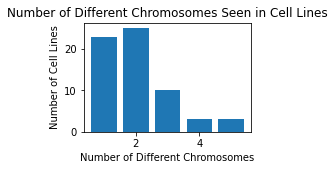

In [156]:
plt.figure(figsize=(3,2))

cl_chroms = ecm2[ecm2.Manualv2.isin([1,3])].dropna(subset=['Chromosome']).groupby('CCLE_Name')['Chromosome'].unique()
chrom_prevalence = np.unique(cl_chroms.apply(len), return_counts=True)
plt.bar(*chrom_prevalence)
plt.title('Number of Different Chromosomes Seen in Cell Lines')
plt.xlabel('Number of Different Chromosomes')
plt.ylabel('Number of Cell Lines')

# Save the chromosome list
#save = pd.DataFrame(cl_chroms.sort_values(key=lambda x: x.str.len(), ascending=False)).reset_index()
#save['Chromosome'] = save['Chromosome'].transform(lambda x: ",".join(map(str,x)))
#save.to_csv('chroms_in_cell_lines.tsv', sep='\t', index=False, na_rep='NA')

pd.DataFrame(cl_chroms.sort_values(key=lambda x: x.str.len(), ascending=False).head(10)).reset_index()
plt.savefig("../CCLE_analysis/figures_for_ECDB_paper/Diff_chr_per_amplicon.svg", format='svg')

In [113]:
save = pd.DataFrame(cl_chroms.sort_values(key=lambda x: x.str.len(), ascending=False)).reset_index()
save

,CCLE_Name,Chromosome
0,COLO320_LARGE_INTESTINE,"[1, 13, 6, 8]"
1,CORL311_LUNG,"[11, 6, 8]"
2,NCIH2170_LUNG,"[1, 17, 8]"
3,CCFSTTG1_CENTRAL_NERVOUS_SYSTEM,"[12, 6, 7]"
4,SNU16_STOMACH,"[10, 11, 8]"
5,Y79_AUTONOMIC_GANGLIA,"[18, 2]"
6,HCC1569_BREAST,"[17, 19]"
7,HCC33_LUNG,"[1, 12]"
8,LAN2_AUTONOMIC_GANGLIA,"[2, 7]"
9,NCIH716_LARGE_INTESTINE,"[10, 8]"


41 cell lines have multiple chromosomes with ecDNA related genes.


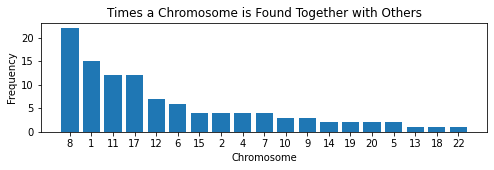

In [157]:
# Most friendly chromosomes
plt.figure(figsize=(8,2))

chrom_occurences = {i:0 for i in ecm2[ecm2.Manualv2.isin([1,3])]['Chromosome'].dropna().unique()}
for chrom in ecm2[ecm2.Manualv2.isin([1,3])]['Chromosome'].dropna().unique():
    for i in cl_chroms:
        if len(i) > 1 and chrom in i:
            chrom_occurences[chrom] += 1
chrom_occurences = dict(sorted(chrom_occurences.items(), key=lambda item: item[1], reverse=True))

print(len(cl_chroms[cl_chroms.apply(len) > 1]), 'cell lines have multiple chromosomes with ecDNA related genes.')
plt.bar(chrom_occurences.keys(), chrom_occurences.values())
plt.title('Times a Chromosome is Found Together with Others')
plt.xlabel('Chromosome')
plt.ylabel('Frequency')
plt.savefig("../CCLE_analysis/figures_for_ECDB_paper/Friendly_chromosomes_gene_diversity.svg", format='svg')

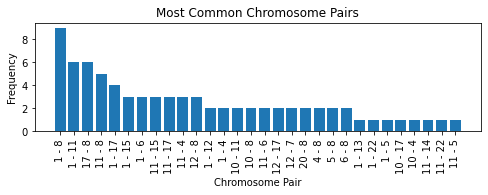

In [158]:
# Most prevalent chromosome pairs
from itertools import combinations

pairs = list(combinations(ecm2[ecm2.Manualv2.isin([1,3])]['Chromosome'].dropna().unique(), 2))
pair_numbers = {pair:0 for pair in pairs}
for pair in pairs:
    for chroms_list in cl_chroms:
        if set(pair).issubset(chroms_list):
            pair_numbers[pair] += 1
pair_numbers = dict(sorted(pair_numbers.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(8,2))

plt.bar([str(f'{i[0]} - {i[1]}') for i in pair_numbers.keys()][:30], list(pair_numbers.values())[:30])
plt.title('Most Common Chromosome Pairs')
plt.xticks(rotation = 90)
plt.xlabel('Chromosome Pair')
plt.ylabel('Frequency')
plt.savefig("../CCLE_analysis/figures_for_ECDB_paper/chrom_pairs.svg", format='svg')